In [1]:
%%bash
pip3 install user_agents
pip3 install tqdm

In [2]:
import numpy as np
import pandas as pd
import pickle
import urllib
from tqdm import tqdm, trange, tqdm_pandas
import os
from user_agents import parse
import datetime
import time
from sklearn import preprocessing
import matplotlib.pyplot as plt
# import pytables

In [3]:
pd.set_option('display.max_columns', 1000)
tqdm.pandas(desc="Progress Bar")

**Dictionary:**

| name          |meaning        | 
| ------------- |:-------------| 
|**data    **      |data_final from data_manipulation table|
|**data_base**    |data with 'ip','city','country' 3 columns dropped|

---
# Import Data:

In [4]:
%%time
# initial inner join data
# df=pickle.load(open( "../Data/df.p", "rb" ) )
# dataframe dropping a few columns
# df0=pickle.load(open( "../Data/df0.p", "rb" ) )
# reorganized main dataframe
with open( "../Data/data_final.p", "rb" )  as f:
    data=pickle.load(f)

CPU times: user 4.04 s, sys: 1.67 s, total: 5.71 s
Wall time: 13.9 s


---
# Feature Engineering Part 1 (Preprocess):
- **df is the final base dataframe we would use**
- **Each subsection of Feature Engineering would update a column of df_groupby2 (can rerun without reload)**

**Have a look at data**

In [5]:
num_row=4
list=np.concatenate((range(0,num_row),range(-num_row,0)),axis=0)
data.iloc[list,:]

,id,num_sess,session_id,finger_print,datetime,days,referrer,page_url,product_viewed_browse,cart_started,basket_paid_browsing,product_name,product_save,product_price,product_time_left,email,Post_Code,cart_startTime,product_viewed_cart,total,basket_paid_cart,payment_type,email_click_through,cart_firstTime,cart_lastTime,basketInfoTime,ip_address,user_agent,city,country,product_id_ProductViewed,product_id_CartStarted,last_cart_started
0,1,1,k79c9lk1nfop9m4wx0fmrg16,5c6eaac3c9db786d83c28c4d673ff556,2017-05-19 08:02:53,19,,https://secure.wowcher.co.uk/checkout/3838997?...,NaT,2017-05-19 08:02:51.292,None,None,None,None,None,None,None,2017-05-19 08:02:51,None,None,False,None,True,2017-05-19 08:02:53+00:00,2017-05-19 08:02:53+00:00,1495182843,77.103.157.226,Mozilla/5.0+(iPhone;+CPU+iPhone+OS+10_3_1+like...,None,GB,NaN,3838997,2017-05-19 08:02:53
1,1,2,w2gunkrgoifz0j4agqb8bz4,5c6eaac3c9db786d83c28c4d673ff556,2017-05-19 13:51:59,19,,https://secure.wowcher.co.uk/checkout/3838997?...,NaT,2017-05-19 08:02:51.292,None,None,None,None,None,None,None,2017-05-19 08:02:51,None,None,False,None,True,2017-05-19 13:51:59+00:00,2017-05-19 13:51:59+00:00,1495203782,77.103.157.226,Mozilla/5.0+(iPhone;+CPU+iPhone+OS+10_3_1+like...,None,GB,NaN,3838997,2017-05-19 13:51:59
2,1,3,14qy38xtlrcnc1lamkqq6fqd84,5c6eaac3c9db786d83c28c4d673ff556,2017-06-02 21:40:06,2,,https://www.wowcher.co.uk/deal/shop/4096138/bl...,NaT,2017-06-02 21:40:06.147,None,Thermal Blackout Curtains - 9 Colours & 5 Sizes!,75%,9,03:01:20:04,None,None,2017-06-02 21:40:06,None,9,False,None,False,2017-06-02 21:40:06+00:00,2017-06-02 21:40:06+00:00,1496441524,77.103.157.226,Mozilla/5.0+(iPhone;+CPU+iPhone+OS+10_3_1+like...,None,GB,NaN,4096138,2017-06-02 21:40:06
3,1,4,1vf4mz1acp57x1p1zlyz5xebe6,5c6eaac3c9db786d83c28c4d673ff556,2017-06-09 14:23:10,9,,https://www.wowcher.co.uk/deal/shop/4096138/bl...,NaT,2017-06-09 14:23:10.017,None,Thermal Blackout Curtains - 9 Colours & 5 Sizes!,75%,9,00:08:36:54,None,None,2017-06-09 14:23:10,None,9,False,None,False,2017-06-09 14:23:10+00:00,2017-06-09 14:23:10+00:00,1497020106,77.103.157.226,Mozilla/5.0+(iPhone;+CPU+iPhone+OS+10_3_1+like...,None,GB,NaN,4096138,2017-06-09 14:23:10
1469181,52433,4,1tz5t8tsg2bdj5c3w6i1r5ufu,3a131efaa20b6a197508313f0eb266c4,2017-06-12 14:28:04,12,,https://www.wowcher.co.uk/deal/travel/3997899/...,2017-06-12 14:28:04.531,NaT,None,3-5nt New York Break with Flights,20%,369,08:08:31:55,sue_terryshannon@yahoo.co.uk,None,2017-06-12 14:16:23,1497276973316,369,False,None,False,2017-06-12 14:15:54+00:00,2017-06-12 14:28:26+00:00,1497279605,86.6.191.124,Mozilla/5.0+(iPhone;+CPU+iPhone+OS+10_2_1+like...,Oxford,GB,3997899,NaN,NaT
1469182,52433,4,1tz5t8tsg2bdj5c3w6i1r5ufu,3a131efaa20b6a197508313f0eb266c4,2017-06-12 14:28:09,12,,https://www.wowcher.co.uk/deal/travel/3997899/...,NaT,2017-06-12 14:28:09.550,None,3-5nt New York Break with Flights,20%,369,08:08:31:55,sue_terryshannon@yahoo.co.uk,None,2017-06-12 14:16:23,1497276973316,369,False,None,False,2017-06-12 14:15:54+00:00,2017-06-12 14:28:26+00:00,1497279605,86.6.191.124,Mozilla/5.0+(iPhone;+CPU+iPhone+OS+10_2_1+like...,Oxford,GB,NaN,3997899,NaT
1469183,52433,4,1tz5t8tsg2bdj5c3w6i1r5ufu,3a131efaa20b6a197508313f0eb266c4,2017-06-12 14:28:09,12,,https://www.wowcher.co.uk/deal/travel/3997899/...,NaT,2017-06-12 14:28:09.554,None,3-5nt New York Break with Flights,20%,369,08:08:31:55,sue_terryshannon@yahoo.co.uk,None,2017-06-12 14:16:23,1497276973316,369,False,None,False,2017-06-12 14:15:54+00:00,2017-06-12 14:28:26+00:00,1497279605,86.6.191.124,Mozilla/5.0+(iPhone;+CPU+iPhone+OS+10_2_1+like...,Oxford,GB,NaN,3997899,2017-06-12 14:28:09
1469184,52433,4,1tz5t8tsg2bdj5c3w6i1r5ufu,3a131efaa20b6a197508313f0eb266c4,2017-06-12 14:28:26,12,,https://www.wowcher.co.uk/deals/travel,NaT,NaT,None,3-5nt New York Break with Flights,20%,369,08:08:31:55,sue_terryshannon@yahoo.co.uk,None,2017-06-12 14:16:23,1497276973316,369,False,None,False,2017-06-12 14:15:54+00:00,2017-06-12 14:28:26+00:00,1497279605,86.6.191.1

## Drop IP, City and Country in data
**Generate data_base, which reduced duplicated rows for many counting related features**

In [6]:
data_base=data.drop(['ip_address','city','country'],axis=1)
data_base.drop_duplicates().shape

(1428378, 30)

In [7]:
print('Pencentage of duplication cause by geolocation:\n',(1469184-1426996)/1469184*100,'%')

Pencentage of duplication cause by geolocation:
 2.8715259627112735 %


In [8]:
data_base.columns

Index(['id', 'num_sess', 'session_id', 'finger_print', 'datetime', 'days',
       'referrer', 'page_url', 'product_viewed_browse', 'cart_started',
       'basket_paid_browsing', 'product_name', 'product_save', 'product_price',
       'product_time_left', 'email', 'Post_Code', 'cart_startTime',
       'product_viewed_cart', 'total', 'basket_paid_cart', 'payment_type',
       'email_click_through', 'cart_firstTime', 'cart_lastTime',
       'basketInfoTime', 'user_agent', 'product_id_ProductViewed',
       'product_id_CartStarted', 'last_cart_started'],
      dtype='object')

In [9]:
print(data_base.shape)
data_base[:3]

(1469185, 30)


,id,num_sess,session_id,finger_print,datetime,days,referrer,page_url,product_viewed_browse,cart_started,basket_paid_browsing,product_name,product_save,product_price,product_time_left,email,Post_Code,cart_startTime,product_viewed_cart,total,basket_paid_cart,payment_type,email_click_through,cart_firstTime,cart_lastTime,basketInfoTime,user_agent,product_id_ProductViewed,product_id_CartStarted,last_cart_started
0,1,1,k79c9lk1nfop9m4wx0fmrg16,5c6eaac3c9db786d83c28c4d673ff556,2017-05-19 08:02:53,19,,https://secure.wowcher.co.uk/checkout/3838997?...,NaT,2017-05-19 08:02:51.292,None,None,None,None,None,None,None,2017-05-19 08:02:51,None,None,False,None,True,2017-05-19 08:02:53+00:00,2017-05-19 08:02:53+00:00,1495182843,Mozilla/5.0+(iPhone;+CPU+iPhone+OS+10_3_1+like...,NaN,3838997,2017-05-19 08:02:53
1,1,2,w2gunkrgoifz0j4agqb8bz4,5c6eaac3c9db786d83c28c4d673ff556,2017-05-19 13:51:59,19,,https://secure.wowcher.co.uk/checkout/3838997?...,NaT,2017-05-19 08:02:51.292,None,None,None,None,None,None,None,2017-05-19 08:02:51,None,None,False,None,True,2017-05-19 13:51:59+00:00,2017-05-19 13:51:59+00:00,1495203782,Mozilla/5.0+(iPhone;+CPU+iPhone+OS+10_3_1+like...,NaN,3838997,2017-05-19 13:51:59
2,1,3,14qy38xtlrcnc1lamkqq6fqd84,5c6eaac3c9db786d83c28c4d673ff556,2017-06-02 21:40:06,2,,https://www.wowcher.co.uk/deal/shop/4096138/bl...,NaT,2017-06-02 21:40:06.147,None,Thermal Blackout Curtains - 9 Colours & 5 Sizes!,75%,9,03:01:20:04,None,None,2017-06-02 21:40:06,None,9,False,None,False,2017-06-02 21:40:06+00:00,2017-06-02 21:40:06+00:00,1496441524,Mozilla/5.0+(iPhone;+CPU+iPhone+OS+10_3_1+like...,NaN,4096138,2017-06-02 21:40:06


**Save data_base**

In [12]:
%%time
with open( "../Data/Feature_Engineering/data_base.p", "wb" ) as f:
    pickle.dump(data_base, f)

CPU times: user 10.1 s, sys: 3.05 s, total: 13.2 s
Wall time: 13.1 s


---
## Load data_base

In [4]:
%%time
with open( "../Data/Feature_Engineering/data_base.p", "rb" )  as f:
    data_base=pickle.load(f)

CPU times: user 3.57 s, sys: 1.61 s, total: 5.18 s
Wall time: 12.4 s


## 1. Time Features
---
### 1.1 Session Dwell time
for one product name / session is fine. what if there's only several product name? is this for session or for 

**Get dwell_time**

In [7]:
%%time
# here I use .first is fine as I only care about datatime and cart_lastTime
df_sess=data_base.groupby(['id','num_sess']).first()

# cart_lastTime is same during a session
# date_time is sorted
last_browsing_time=pd.to_datetime(df_sess.cart_lastTime.values)
first_browsing_time=pd.to_datetime(df_sess.datetime.values)
df_sess['dwell_time']=last_browsing_time-first_browsing_time

CPU times: user 4.02 s, sys: 443 ms, total: 4.46 s
Wall time: 4.46 s


In [8]:
print(df_sess.shape)
df_sess.loc[[2]]

(220047, 29)


session_id                      finger_print  \
id num_sess                                                                 
2  1          qvsw8ty43cbb15tu52ujywjs3  e5f3ca057208f51a2cacae58ff95d757   
   2           xe1kopsb1o573zhid3i51eds  e5f3ca057208f51a2cacae58ff95d757   
   3         184grb3zg9udt1scfxr2697n5b  e5f3ca057208f51a2cacae58ff95d757   
   4          11expdzyaf01l4rt3b953me14  e5f3ca057208f51a2cacae58ff95d757   

                       datetime  days referrer  \
id num_sess                                      
2  1        2017-05-26 13:25:27    26            
   2        2017-06-09 13:20:22     9            
   3        2017-06-12 08:32:26    12            
   4        2017-06-14 13:50:01    14            

                                                      page_url  \
id num_sess                                                      
2  1         https://www.wowcher.co.uk/email-deals/travel/4...   
   2         https://www.wowcher.co.uk/email-deals/travel/4...   
   3         https://www.wowcher.co.uk/deal/shop/4212459/mo...   
   4         https://www.wowcher.co.uk/email-deals/travel/4...   

                    product_viewed_browse                  cart_started  \
id num_sess                                                               
2  1        2017-05-26 13:25:20.268000000 2017-05-26 13:25:20.891000064   
   2        2017-06-09 13:20:30.129999872 2017-06-09 13:20:30.748999936   
   3        2017-06-12 08:32:43.032999936 2017-06-12 08:32:44.376999936   
   4        2017-06-14 13:49:41.153999872 2017-06-14 13:49:41.772000000   

            basket_paid_browsing  \
id num_sess                        
2  1                        None   
   2                        None   
   3                        None   
   4                        None   

                                                  product_name product_save  \
id num_sess                                                                   
2  1                        3 5 or 7nt Algarve Break & Flights          26%   
   2         7nt 4* All-Inclusive Croatia & Flights - Summe...          27%   
   3                 Modern Shaggy Rug - 10 Colours & 6 Sizes!          64%   
   4              7nt All-Inclusive Mallorca Holiday & Flights          35%   

            product_price product_time_left email Post_Code  \
id num_sess                                                   
2  1                   69       06:09:34:40  None      None   
   2                  229       04:09:39:29  None      None   
   3                    9       03:14:27:15  None      None   
   4                  259       06:09:09:13  None      None   

                  cart_startTime product_viewed_cart total basket_paid_cart  \
id num_sess                                                                   
2  1         2017-05-26 13:25:20                None    69            False   
   2         2017-06-09 13:20:30                None   229            False   
   3         2017-06-12 08:32:44                None     9            False   
   4         2017-06-14 13:49:41       1497448247032   259            False   

            payment_type email_click_through            cart_firstTime  \
id num_sess                                                              
2  1                None               False 2017-05-26 13:25:27+00:00   
   2                None               False 2017-06-09 13:20:23+00:00   
   3                None               False 2017-06-12 08:32:26+00:00   
   4                None               False 2017-06-14 13:50:02+00:00   

                        cart_lastTime basketInfoTime  \
id num_sess                                            
2  1        2017-05-26 13:25:27+00:00     1495807024   
   2        2017-06-09 13:20:23+00:00     1497016328   
   3        2017-06-12 08:32:26+00:00     1497258247   
   4        2017-06-14 13:51:09+00:00     1497450182   

                                                    user_agent  \
id num_sess            

In [9]:
df_DwellTime=df_sess['dwell_time']
print(df_DwellTime.shape)
df_DwellTime.loc[[1,2,3]]

(220047,)


id  num_sess
1   1          00:00:00
    2          00:00:00
    3          00:00:00
    4          00:00:00
2   1          00:00:00
    2          00:00:01
    3          00:00:00
    4          00:01:08
3   1          00:01:22
    2          00:05:56
    3          00:00:05
Name: dwell_time, dtype: timedelta64[ns]

**Concert to seconds**

In [10]:
df_DwellTime=df_DwellTime.apply(lambda x: x.total_seconds() if not pd.isnull(x) else 0)

In [11]:
df_DwellTime.loc[[1,2,3]]

id  num_sess
1   1             0.0
    2             0.0
    3             0.0
    4             0.0
2   1             0.0
    2             1.0
    3             0.0
    4            68.0
3   1            82.0
    2           356.0
    3             5.0
Name: dwell_time, dtype: float64

**Plot dwell time**

In [12]:
type(df_DwellTime)

pandas.core.series.Series

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


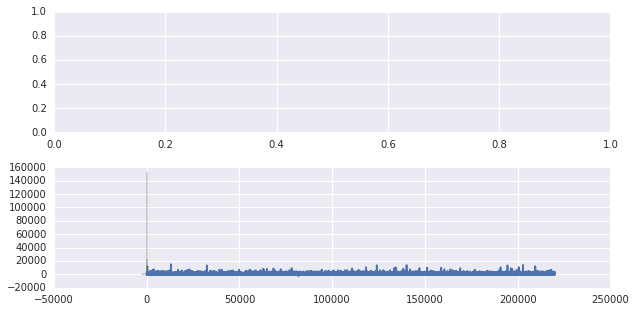

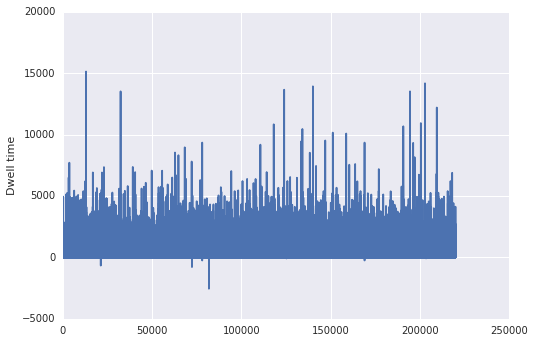

In [30]:
plt.plot(df_DwellTime.tolist())
plt.ylabel('Dwell time')
plt.show()

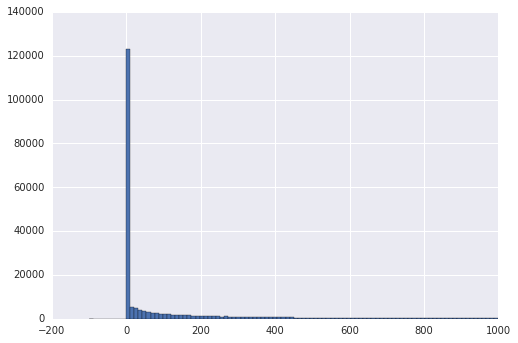

In [20]:
plt.subplots()
df_DwellTime.hist(bins=100,range=(-100,1000))

In [29]:
np.mean(df_DwellTime.tolist())

209.9402627620463

- **save df_DwellTime**

In [18]:
%%time
with open( "../Data/Feature_Engineering/df_DwellTime.p", "wb" ) as f:
    pickle.dump(df_DwellTime, f)

CPU times: user 4 ms, sys: 3 ms, total: 7 ms
Wall time: 7.17 ms


**Example of concatenate features:**

In [21]:
# df_feature=pd.concat([df_DwellTime, df_productID], axis=1)

In [ ]:
# df_feature[:3]

---
### 1.2 Weekday
all these weekdays, month, days, etc are session start time

In [22]:
df_sess=data_base.groupby(['id','num_sess']).first()
df_sess.datetime[0]

Timestamp('2017-05-19 08:02:53')

In [23]:
# Monday is 0, Sunday is 6
df_sess['weekday'] = df_sess.datetime.apply(lambda x: x.dayofweek).values

In [24]:
df_WeekDay=df_sess['weekday'].copy()

In [25]:
num_row=4
list=np.concatenate((range(0,num_row),range(-num_row,0)),axis=0)
print(df_WeekDay.shape)
df_WeekDay.iloc[list]

(220047,)


id     num_sess
1      1           4
       2           4
       3           4
       4           4
52433  1           2
       2           0
       3           0
       4           0
Name: weekday, dtype: int64

**Save df_WeekDay:**

In [26]:
%%time
with open( "../Data/Feature_Engineering/df_WeekDay.p", "wb" ) as f:
    pickle.dump(df_WeekDay, f )

CPU times: user 3 ms, sys: 5 ms, total: 8 ms
Wall time: 7.12 ms


---
### 1.3 Month

In [27]:
df_sess=data_base.groupby(['id','num_sess']).first()
df_sess.datetime[0]

Timestamp('2017-05-19 08:02:53')

In [28]:
df_sess['month'] = df_sess.datetime.apply(lambda x: x.month).values

In [29]:
df_month=df_sess['month'].copy()

In [30]:
num_row=4
list=np.concatenate((range(0,num_row),range(-num_row,0)),axis=0)
print(df_month.shape)
df_month.iloc[list]

(220047,)


id     num_sess
1      1           5
       2           5
       3           6
       4           6
52433  1           5
       2           6
       3           6
       4           6
Name: month, dtype: int64

**Save df_month:**

In [31]:
%%time
with open( "../Data/Feature_Engineering/df_month.p", "wb" ) as f:
    pickle.dump(df_month, f )

CPU times: user 3 ms, sys: 3 ms, total: 6 ms
Wall time: 5.49 ms


---
### 1.4 Time of Day (TBD)
**Session start time.**

In [32]:
df_sess=data_base.groupby(['id','num_sess']).first()
df_sess.datetime.values

array(['2017-05-19T08:02:53.000000000', '2017-05-19T13:51:59.000000000',
       '2017-06-02T21:40:06.000000000', ...,
       '2017-06-12T14:03:52.000000000', '2017-06-12T14:03:52.000000000',
       '2017-06-12T14:15:41.000000000'], dtype='datetime64[ns]')

**transform the data to timestamp form**

In [33]:
a=pd.to_datetime(df_sess[:1].datetime.values)
a[0]

Timestamp('2017-05-19 08:02:53')

In [34]:
a[0].time()

datetime.time(8, 2, 53)

In [35]:
tmp=df_sess.datetime.apply(lambda x: pd.to_datetime(x).time()).values
df_sess['time_of_day']=tmp # this is an array

In [36]:
df_TimeOfDay=df_sess['time_of_day'].copy()

In [37]:
num_row=4
list=np.concatenate((range(0,num_row),range(-num_row,0)),axis=0)
print(df_TimeOfDay.shape)
df_TimeOfDay.iloc[list]

(220047,)


id     num_sess
1      1           08:02:53
       2           13:51:59
       3           21:40:06
       4           14:23:10
52433  1           18:48:37
       2           14:03:52
       3           14:03:52
       4           14:15:41
Name: time_of_day, dtype: object

**Transform to seconds**

In [38]:
def hms_to_seconds(t):
    h, m, s = [int(i) for i in t.split(':')]
    return 3600*h + 60*m + s

In [39]:
df_TimeOfDay=df_TimeOfDay.apply(lambda x: hms_to_seconds(str(x)))

In [40]:
df_TimeOfDay[:3]

id  num_sess
1   1           28973
    2           49919
    3           78006
Name: time_of_day, dtype: int64

**Save df_TimeOfDay:**

In [41]:
%%time
with open( "../Data/Feature_Engineering/df_TimeOfDay.p", "wb" ) as f:
    pickle.dump(df_TimeOfDay, f )

CPU times: user 1e+03 µs, sys: 7 ms, total: 8 ms
Wall time: 6.63 ms


---
### 1.5 last_CartStartedTime (not feature)
In wowcher data, there's no proper cart. Possible useful features could be cart dwell time (cart time), more detailed dwell time of a certain product page etc.
<br> here only use the last nonNull cart_started time, ie. last_cart_started
<br>这边在作弊了。。。这样算出来的cart_dwellTime其实不准，那些没买的基本就是cart_dwellTime=0了。。。

**Replace 0 in product_id_CartStarted to nan**

In [124]:
data_base0=data_base.copy()
data_base0['product_id_CartStarted'].replace({0:np.nan},inplace=True)

**Find last valid product_id_CartStarted and corresponding datetime (as last_cart_startedTime) for each num_sess**

In [43]:
df_last_CartStartedTime=data_base0[['id','num_sess','product_id_CartStarted','datetime']]\
                                .groupby(['id','num_sess']).nth(-1,dropna='any')

In [44]:
print(df_last_CartStartedTime['datetime'].shape)
print(df_sess.cart_lastTime.shape)

(220047,)
(220047,)


In [45]:
df_last_CartStartedTime['datetime'].fillna(0, inplace=True)

In [46]:
%%time
with open( "../Data/Feature_Engineering/df_last_CartStartedTime.p", "wb" ) as f:
    pickle.dump(df_last_CartStartedTime['datetime'], f)

CPU times: user 4 ms, sys: 2 ms, total: 6 ms
Wall time: 5.81 ms


### 1.6 Cart_DwellTime

**Load df_last_CartStartedTime & data_base**

In [47]:
%%time
with open( "../Data/Feature_Engineering/df_last_CartStartedTime.p", "rb" ) as f:
    df_last_CartStartedTime = pickle.load(f)
    
with open( "../Data/Feature_Engineering/data_base.p", "rb" )  as f:
    data_base = pickle.load(f)

CPU times: user 3.89 s, sys: 1.61 s, total: 5.5 s
Wall time: 5.49 s


**get Cart_StartedTime**

In [48]:
# cart_first_time and cart_last_time are all same during a session
cart_started=pd.to_datetime(df_last_CartStartedTime.values)
cart_last_time=pd.to_datetime(df_sess.cart_lastTime.values)
# assign new columns:
df_sess['cart_DwellTime']=cart_last_time-cart_started

In [49]:
df_CartDwellTime=df_sess['cart_DwellTime'].copy()

In [50]:
num_row=4
list=np.concatenate((range(0,num_row),range(-num_row,0)),axis=0)
print(df_CartDwellTime.shape)
df_CartDwellTime.iloc[list]

(220047,)


id     num_sess
1      1          00:00:00
       2          00:00:00
       3          00:00:00
       4          00:00:00
52433  1          00:00:00
       2          00:00:00
       3          00:00:00
       4          00:00:17
Name: cart_DwellTime, dtype: timedelta64[ns]

In [51]:
df_CartDwellTime.loc[52426]

num_sess
1       0 days 00:00:00
2   17308 days 10:42:14
3       0 days 00:04:03
4       0 days 00:00:00
5   17320 days 10:47:06
Name: cart_DwellTime, dtype: timedelta64[ns]

**Tranform time to seconds**

In [52]:
df_CartDwellTime=df_CartDwellTime.apply(lambda x: x.total_seconds() if not pd.isnull(x) else 0)
print(df_CartDwellTime.shape)

(220047,)


In [53]:
df_CartDwellTime[df_CartDwellTime<0]=0

In [54]:
df_CartDwellTime[df_CartDwellTime>86400]=0

In [55]:
print('number of having df_CartDwellTime positive: ',sum(df_CartDwellTime!=0))

number of having df_CartDwellTime positive:  35067


In [56]:
df_CartDwellTime[:3]

id  num_sess
1   1           0.0
    2           0.0
    3           0.0
Name: cart_DwellTime, dtype: float64

**Save df_CartDwellTime:**

In [57]:
%%time
with open( "../Data/Feature_Engineering/df_CartDwellTime.p", "wb" ) as f:
    pickle.dump(df_CartDwellTime, f)

CPU times: user 4 ms, sys: 3 ms, total: 7 ms
Wall time: 6.19 ms


### 1.7 Product_time_left

**Load data_base**

In [58]:
%%time
with open( "../Data/Feature_Engineering/data_base.p", "rb" )  as f:
    data_base = pickle.load(f)

CPU times: user 4.31 s, sys: 1.73 s, total: 6.04 s
Wall time: 6.04 s


**transform product_time_left to seconds**

In [59]:
df_sess=data_base.groupby(['id','num_sess']).first()

In [60]:
df_sess.product_time_left[:5]

id  num_sess
1   1                  None
    2                  None
    3           03:01:20:04
    4           00:08:36:54
2   1           06:09:34:40
Name: product_time_left, dtype: object

In [61]:
def product_time_left(timeleft):
    if not timeleft == None:
        try:
            if(timeleft[timeleft.rfind(':')+1:]!='60'):
                t = datetime.datetime.strptime(timeleft, "%d:%H:%M:%S")
                delta = datetime.timedelta(days=t.day, hours=t.hour, minutes=t.minute, seconds=t.second)
                return delta.total_seconds()
            else:
                timeleft = timeleft[:timeleft.rfind(':')+1]+"00"
                t = datetime.datetime.strptime(timeleft, "%d:%H:%M:%S")
                delta = datetime.timedelta(days=t.day, hours=t.hour, minutes=t.minute, seconds=t.second)
                return delta.total_seconds()
        except ValueError:
            if ':' in timeleft and 'NaN' not in timeleft: #filter some strange uncleaned terms out
                timeleft = timeleft[timeleft.index(':')+1:]
                t = datetime.datetime.strptime(timeleft, "%H:%M:%S")
                delta = datetime.timedelta(hours=t.hour, minutes=t.minute, seconds=t.second)
                return delta.total_seconds()
            else:
                return 0
    else:
        return 0

In [62]:
%%time
df_sess.product_time_left = df_sess['product_time_left'].apply(lambda x: product_time_left(x))

CPU times: user 3.3 s, sys: 20 ms, total: 3.32 s
Wall time: 3.32 s


In [63]:
df_ProductTimeLeft=df_sess.product_time_left
df_ProductTimeLeft.shape

(220047,)

**Save df_ProductTimeLeft**

In [64]:
%%time
with open( "../Data/Feature_Engineering/df_ProductTimeLeft.p", "wb" ) as f:
    pickle.dump(df_ProductTimeLeft, f)

CPU times: user 3 ms, sys: 3 ms, total: 6 ms
Wall time: 5.98 ms


### 1.8 date_time

**Load data_base**

In [4]:
%%time
with open( "../Data/Feature_Engineering/data_base.p", "rb" )  as f:
    data_base = pickle.load(f)

CPU times: user 3.66 s, sys: 1.36 s, total: 5.02 s
Wall time: 5.02 s


**Create datatime feature**

In [10]:
df_sess=data_base.groupby(['id','num_sess']).first()

In [12]:
# timestamp function to 
def absolute_time(datetime):
    return time.mktime(datetime.timetuple())

In [16]:
df_dateTime = df_sess['datetime'].apply(lambda x: absolute_time(x) if not pd.isnull(x) else 0)

In [19]:
print(df_dateTime.shape)
df_dateTime[:5]

(220047,)


id  num_sess
1   1           1.495181e+09
    2           1.495202e+09
    3           1.496440e+09
    4           1.497018e+09
2   1           1.495805e+09
Name: datetime, dtype: float64

**Save df_dateTime**

In [20]:
%%time
with open( "../Data/Feature_Engineering/df_dateTime.p", "wb" ) as f:
    pickle.dump(df_dateTime, f)

CPU times: user 5 ms, sys: 3 ms, total: 8 ms
Wall time: 16.5 ms


## 2. Catefories Features
---
### 2.1 #Page viewed within a session
This is a measurement of how active the customer is for each session

**Load data_base**

In [9]:
%%time
with open( "../Data/Feature_Engineering/data_base.p", "rb" )  as f:
    data_base=pickle.load(f)

CPU times: user 3.83 s, sys: 1.64 s, total: 5.46 s
Wall time: 5.58 s


Can only be run at once for this section

In [10]:
tmp=data_base[['id','num_sess','page_url']].copy()

page_count_sess=tmp.groupby(['id','num_sess']).page_url.nunique()
# page_count_sess=page_count_sess.reset_index().copy()
page_count_sess.rename(columns={'page_url':'page_count_sess'},inplace=True)
# tmp01=pd.merge(df_page_sess.reset_index(),page_count_sess[['id','num_sess','page_count_sess']]
#                , how='inner', on=['id','num_sess'])

# df_page_sess=tmp01.groupby(['id','num_sess','product_name'],sort=False).first()

id     num_sess
1      1            1
       2            1
       3            1
       4            1
2      1            1
       2            1
       3            1
       4            2
3      1            2
       2            1
       3            1
4      1            1
       2            1
       3            1
5      1            1
       2            1
       3            1
6      1            5
       2            1
       3            3
7      1            1
       2            1
       3            1
8      1            4
       2            4
       3            3
       4            2
       5            3
9      1            1
       2            1
                   ..
52425  4            2
       5            2
52426  1            1
       2            2
       3            9
       4            1
       5            1
52427  1            1
       2            1
       3            1
52428  1            4
       2            1
       3           11
52429  1        

In [11]:
num_row=4
list=np.concatenate((range(0,num_row),range(-num_row,0)),axis=0)
print(page_count_sess.shape)
page_count_sess.iloc[list]

(220047,)


id     num_sess
1      1            1
       2            1
       3            1
       4            1
52433  1            1
       2            1
       3            1
       4           10
dtype: int64

In [12]:
df_PageCount=page_count_sess.copy()

In [13]:
df_PageCount.shape

(220047,)

**Check (id = 52433, num_sess=[1,2,3])**

In [163]:
data_base[(data_base['id']==52433)&(data_base['num_sess'].isin([1,2,3]))]

,id,num_sess,session_id,finger_print,datetime,days,referrer,page_url,product_viewed_browse,cart_started,basket_paid_browsing,product_name,product_save,product_price,product_time_left,email,Post_Code,cart_startTime,product_viewed_cart,total,basket_paid_cart,payment_type,email_click_through,cart_firstTime,cart_lastTime,basketInfoTime,user_agent,product_id_ProductViewed,product_id_CartStarted,last_cart_started
1469154,52433,1,zxkbfysuold2vl2v4el3ubzv,17e96f528f8940c9392619c58b8b136d,2017-05-24 18:48:37,24,https://www.wowcher.co.uk/deal/shop/3997409/9-...,https://secure.wowcher.co.uk/checkout/3949698?...,NaT,2017-05-24 18:48:36.464,None,9-Seater XL Grey Rattan Garden Dining Sofa Set,48%,509.00,02:04:20:57,sue_terryshannon@yahoo.co.uk,Rm17 6ax,2017-05-24 18:43:00,None,509.00,False,paypalExpress,False,2017-05-24 18:43:00+00:00,2017-05-24 18:48:37+00:00,1495653603,Mozilla/5.0+(iPad;+CPU+OS+9_3_5+like+Mac+OS+X)...,NaN,3949698,2017-05-24 18:48:37
1469155,52433,2,vxhv5kka1iu93rtmz4g6osc4,de6f52700a2fefcd15e803abbe23cde1,2017-06-12 14:03:52,12,https://www.wowcher.co.uk/deal/shop/4211595/9-...,https://secure.wowcher.co.uk/checkout/4211595?...,NaT,2017-06-12 14:03:52.170,None,9-Seater XL Grey Rattan Garden Dining Sofa Set,48%,509.00,01:08:56:14,sue_terryshannon@yahoo.co.uk,None,2017-06-12 14:03:52,None,509.00,False,None,False,2017-06-12 14:03:52+00:00,2017-06-12 14:03:52+00:00,1497278104,Mozilla/5.0+(iPhone;+CPU+iPhone+OS+10_3_2+like...,NaN,4211595,2017-06-12 14:03:52
1469156,52433,3,15ox967rdf7q3yjn65eedevsh,de6f52700a2fefcd15e803abbe23cde1,2017-06-12 14:03:52,12,https://www.wowcher.co.uk/deal/shop/4211595/9-...,https://secure.wowcher.co.uk/checkout/4211595?...,NaT,2017-06-12 14:03:52.155,None,9-Seater XL Grey Rattan Garden Dining Sofa Set,48%,509.00,01:08:56:14,sue_terryshannon@yahoo.co.uk,None,2017-06-12 14:03:52,None,509.00,False,None,False,2017-06-12 14:03:14+00:00,2017-06-12 14:03:52+00:00,1497278104,Mozilla/5.0+(iPhone;+CPU+iPhone+OS+10_3_2+like...,NaN,4211595,2017-06-12 14:03:52


**Save df_update:**

In [14]:
%%time
with open( "../Data/Feature_Engineering/df_PageCount.p", "wb" ) as f:
    pickle.dump(df_PageCount, f)

CPU times: user 7 ms, sys: 5 ms, total: 12 ms
Wall time: 31.9 ms


---
### 2.2 #Product browsed count
This is a measure of how active a customer for looking at a product

**Load data_sess**

In [71]:
%%time
with open( "../Data/Feature_Engineering/data_base.p", "rb" )  as f:
    data_base=pickle.load(f)

CPU times: user 4.21 s, sys: 797 ms, total: 5.01 s
Wall time: 5.01 s


**Generate df_ProductCountSess**

In [72]:
df_ProductCount=data_base.groupby(['id','num_sess'])['product_id_ProductViewed'].nunique()

**Save df_ProductCountSess**

In [73]:
%%time
with open( "../Data/Feature_Engineering/df_ProductCount.p", "wb" ) as f:
    pickle.dump(df_ProductCount, f)

CPU times: user 3 ms, sys: 4 ms, total: 7 ms
Wall time: 5.66 ms


---
### *** Last Product In Cart

**Load data_base**

In [21]:
%%time
with open( "../Data/Feature_Engineering/data_base.p", "rb" )  as f:
    data_base=pickle.load(f)

CPU times: user 4.14 s, sys: 1.58 s, total: 5.71 s
Wall time: 5.71 s


**Generate df_ProductInCart and df_lastProductInCart**

In [22]:
data_base.columns

Index(['id', 'num_sess', 'session_id', 'finger_print', 'datetime', 'days',
       'referrer', 'page_url', 'product_viewed_browse', 'cart_started',
       'basket_paid_browsing', 'product_name', 'product_save', 'product_price',
       'product_time_left', 'email', 'Post_Code', 'cart_startTime',
       'product_viewed_cart', 'total', 'basket_paid_cart', 'payment_type',
       'email_click_through', 'cart_firstTime', 'cart_lastTime',
       'basketInfoTime', 'user_agent', 'product_id_ProductViewed',
       'product_id_CartStarted', 'last_cart_started'],
      dtype='object')

In [23]:
df_LastProductInCart=data_base.groupby(['id','num_sess'])['product_id_CartStarted'].last()

In [24]:
df_LastProductInCart[:5]
# Wrong!!!!! need to substitute 0 to be NaN

id  num_sess
1   1           3838997
    2           3838997
    3           4096138
    4           4096138
2   1           4009686
Name: product_id_CartStarted, dtype: object

**Save df_LastProductInCart**

In [27]:
%%time
with open( "../Data/Feature_Engineering/df_lastProductInCart.p", "wb" ) as f:
    pickle.dump(df_LastProductInCart, f)

CPU times: user 40 ms, sys: 5 ms, total: 45 ms
Wall time: 44.6 ms


---
### 2.3Popularity of final Product in cart - (product_viewed Edition)

**Load data_base and df_lastProductInCart**

In [25]:
%%time
with open( "../Data/Feature_Engineering/data_base.p", "rb" )  as f:
    data_base=pickle.load(f)
with open( "../Data/Feature_Engineering/df_lastProductInCart.p", "rb" ) as f:
    df_lastProductInCart=pickle.load(f)

CPU times: user 4.74 s, sys: 1.72 s, total: 6.46 s
Wall time: 6.65 s


**Generate popularity measure by count product_viewed**
- 点一点每个product_id_ProductViewed有多少个，做成dictionary

In [26]:
data_base.columns

Index(['id', 'num_sess', 'session_id', 'finger_print', 'datetime', 'days',
       'referrer', 'page_url', 'product_viewed_browse', 'cart_started',
       'basket_paid_browsing', 'product_name', 'product_save', 'product_price',
       'product_time_left', 'email', 'Post_Code', 'cart_startTime',
       'product_viewed_cart', 'total', 'basket_paid_cart', 'payment_type',
       'email_click_through', 'cart_firstTime', 'cart_lastTime',
       'basketInfoTime', 'user_agent', 'product_id_ProductViewed',
       'product_id_CartStarted', 'last_cart_started'],
      dtype='object')

In [27]:
pop_dict_prod=data_base['product_id_ProductViewed'].value_counts()
print(pop_dict_prod.shape)
pop_dict_prod_resetIndex=pop_dict_prod.reset_index()
pop_dict_prod[:5]

(7443,)


0          154072
4096588      3913
3839768      1714
3173397      1660
4031900      1555
Name: product_id_ProductViewed, dtype: int64

In [28]:
# delete the row with index=0
pop_dict_prod_resetIndex = pop_dict_prod_resetIndex[1:]
pop_dict_prod_resetIndex[:5]

,index,product_id_ProductViewed
1,4096588,3913
2,3839768,1714
3,3173397,1660
4,4031900,1555
5,4020841,1508


- 这个函数来点当前的Product_id（in last cart）在product_id_ProductViewed里面出现过多少次

In [29]:
def pop_count_ByProductViewed(x):
    try:
        return pop_dict_prod_resetIndex[x==pop_dict_prod_resetIndex['index']]['product_id_ProductViewed'].values[0]
    except IndexError:
        return 0

In [30]:
# eg.:
print(pop_count_ByProductViewed('4096588'))
print(pop_count_ByProductViewed(0))
print(pop_count_ByProductViewed(np.nan))

3913
0
0


In [33]:
df_PopByViewed=df_lastProductInCart.progress_apply(lambda x: pop_count_ByProductViewed(x))

Progress Bar: 100%|██████████| 220047/220047 [07:10<00:00, 510.86it/s]


In [62]:
print(df_PopByViewed.shape)
df_PopByViewed[:8]

(220047,)


id  num_sess
1   1            761
    2            761
    3            286
    4            286
2   1            710
    2           1202
    3             19
    4            829
Name: product_id_CartStarted, dtype: int64

---

In [39]:
with open( "../Data/Feature_Engineering/df_PopByViewed.p", "rb" ) as f:
    df_PopByViewed=pickle.load(f)

In [40]:
df_PopByViewed.name='PopByViewed'

---

**Save df_PopByViewed**

In [41]:
%%time
with open( "../Data/Feature_Engineering/df_PopByViewed.p", "wb" ) as f:
    pickle.dump(df_PopByViewed, f)

CPU times: user 4 ms, sys: 7 ms, total: 11 ms
Wall time: 41 ms


### 2.4 Popularity of final Product in cart - (cart_started Edition)

**Load data_base & df_lastProductInCart**

In [63]:
%%time
with open( "../Data/Feature_Engineering/data_base.p", "rb" )  as f:
    data_base=pickle.load(f)
with open( "../Data/Feature_Engineering/df_lastProductInCart.p", "rb" ) as f:
    df_lastProductInCart=pickle.load(f)

CPU times: user 4.53 s, sys: 2.03 s, total: 6.56 s
Wall time: 6.56 s


**Generate popularity measure by count Cart_Started**
- 点一点每个product_id_CartStarted有多少个，做成dictionary

In [64]:
data_base.columns

Index(['id', 'num_sess', 'session_id', 'finger_print', 'datetime', 'days',
       'referrer', 'page_url', 'product_viewed_browse', 'cart_started',
       'basket_paid_browsing', 'product_name', 'product_save', 'product_price',
       'product_time_left', 'email', 'Post_Code', 'cart_startTime',
       'product_viewed_cart', 'total', 'basket_paid_cart', 'payment_type',
       'email_click_through', 'cart_firstTime', 'cart_lastTime',
       'basketInfoTime', 'user_agent', 'product_id_ProductViewed',
       'product_id_CartStarted', 'last_cart_started'],
      dtype='object')

In [66]:
pop_dict_cart=data_base['product_id_CartStarted'].value_counts()
print(pop_dict_cart.shape)
pop_dict_cart_resetIndex=pop_dict_cart.reset_index()
pop_dict_cart[:5]

(5426,)


0          191454
4096588      8122
4031900      5727
3750568      5635
3173397      5495
Name: product_id_CartStarted, dtype: int64

In [68]:
# delete the row with index=0
pop_dict_cart_resetIndex = pop_dict_cart_resetIndex[1:]
pop_dict_cart_resetIndex[:5]

,index,product_id_CartStarted
1,4096588,8122
2,4031900,5727
3,3750568,5635
4,3173397,5495
5,3938318,3921


- 这个函数来点当前的Product_id（in last cart）在product_id_CartStarted里面出现过多少次

In [71]:
def pop_count_ByCartStarted(x):
    try:
        return pop_dict_cart_resetIndex[x==pop_dict_cart_resetIndex['index']]['product_id_CartStarted'].values[0]
    except IndexError:
        return 0

In [72]:
# eg.:
print(pop_count_ByCartStarted('4096588'))
print(pop_count_ByCartStarted(0))
print(pop_count_ByCartStarted(np.nan))

8122
0
0


In [73]:
df_PopByCart=df_LastProductInCart.progress_apply(lambda x: pop_count_ByCartStarted(x))

Progress Bar: 100%|██████████| 220047/220047 [07:28<00:00, 491.01it/s]


In [74]:
print(df_PopByCart.shape)
df_PopByCart[:8]

(220047,)


id  num_sess
1   1           3465
    2           3465
    3            736
    4            736
2   1           1420
    2           2738
    3             43
    4           1799
Name: product_id_CartStarted, dtype: int64

---

In [49]:
with open( "../Data/Feature_Engineering/df_PopByCart.p", "rb" ) as f:
    df_PopByCart = pickle.load(f)

In [50]:
df_PopByCart.name='PopByCart'

In [51]:
df_PopByCart[:3]

id  num_sess
1   1           3465
    2           3465
    3            736
Name: PopByCart, dtype: int64

---

**Save df_PopByCart**

In [52]:
%%time
with open( "../Data/Feature_Engineering/df_PopByCart.p", "wb" ) as f:
    pickle.dump(df_PopByCart, f)

CPU times: user 5 ms, sys: 5 ms, total: 10 ms
Wall time: 9.72 ms


---
### 2.5 Porpularity of final Product in cart - (Purchased Edition)

Would come back to this when label is done 

---
### 2.6 Email providor

**Load data_base**

In [5]:
%%time
with open( "../Data/Feature_Engineering/data_base.p", "rb" )  as f:
    data_base=pickle.load(f)

CPU times: user 3.92 s, sys: 1.54 s, total: 5.45 s
Wall time: 5.45 s


**Count email:**

In [6]:
tmp=data_base.sort_values(['id','num_sess','email'], ascending=[True,True,False])
df_email = tmp.groupby(['id','num_sess']).first()
print('# email null in df_email is: \n',sum(df_email.email.apply(lambda x: x==None)))
print('size of df_email:\n', df_email.shape[0])

# email null in df_email is: 
 57372
size of df_email:
 220047


**email provider function**

In [7]:
def email_provider(email):  
    email = email.lower()
    return email.split('@')[1].split('.')[0]

In [8]:
email_provider(df_email.email.iloc[91803])

'aol'

In [9]:
df_email.email=df_email.email.progress_apply(lambda x: email_provider(x) if not pd.isnull(x) else 'nun')

Progress Bar: 100%|██████████| 220047/220047 [00:00<00:00, 422476.19it/s]


In [10]:
print(df_email.shape)
df_email.loc[[1,2000],:]

(220047, 28)


session_id                      finger_print  \
id   num_sess                                                                 
1    1           k79c9lk1nfop9m4wx0fmrg16  5c6eaac3c9db786d83c28c4d673ff556   
     2            w2gunkrgoifz0j4agqb8bz4  5c6eaac3c9db786d83c28c4d673ff556   
     3         14qy38xtlrcnc1lamkqq6fqd84  5c6eaac3c9db786d83c28c4d673ff556   
     4         1vf4mz1acp57x1p1zlyz5xebe6  5c6eaac3c9db786d83c28c4d673ff556   
2000 1          j9w8zmjs7et71h9zjnhvy8x3e  5d1cbe1850d2ef372568a01081d6f548   
     2           8pjrk1nrfl0ntndfysb9046i  5d1cbe1850d2ef372568a01081d6f548   
     3           o41lumrzu4arg94iiaz0qmll  5d1cbe1850d2ef372568a01081d6f548   
     4         1kdo851g2wol61d18fy3ub79j7  5d1cbe1850d2ef372568a01081d6f548   
     5          183zjbajje2ga1rma0uae3uhj  5d1cbe1850d2ef372568a01081d6f548   
     6          1umkum1623h2i8t9f6ewhkafi  5d1cbe1850d2ef372568a01081d6f548   
     7           qz9q18evh7fwajorozfqmfo4  5d1cbe1850d2ef372568a01081d6f548   
     8           68e6cd539kdddb3lgexbqb7w  5d1cbe1850d2ef372568a01081d6f548   
     9         18x0649akpilt1exeipgydesc4  0dec8ca8eedb6d7f0598a8897fb9e7e2   

                         datetime  days  \
id   num_sess                             
1    1        2017-05-19 08:02:53    19   
     2        2017-05-19 13:51:59    19   
     3        2017-06-02 21:40:06     2   
     4        2017-06-09 14:23:10     9   
2000 1        2017-05-22 07:40:09    22   
     2        2017-05-22 08:44:02    22   
     3        2017-06-05 10:11:35     5   
     4        2017-06-06 08:00:37     6   
     5        2017-06-06 09:12:54     6   
     6        2017-06-07 14:15:56     7   
     7        2017-06-08 14:56:01     8   
     8        2017-06-09 15:00:17     9   
     9        2017-06-14 14:34:53    14   

                                                        referrer  \
id   num_sess                                                      
1    1                                                             
     2                                                             
     3                                                             
     4                                                             
2000 1                                                             
     2                                                             
     3         https://www.wowcher.co.uk/email-deals/travel/4...   
     4         https://www.wowcher.co.uk/email-deals/liverpoo...   
     5         https://www.wowcher.co.uk/email-deals/liverpoo...   
     6         https://www.wowcher.co.uk/email-deals/travel/3...   
     7         https://www.wowcher.co.uk/deal/travel/3998003/...   
     8         https://www.wowcher.co.uk/email-deals/liverpoo...   
     9         https://www.wowcher.co.uk/email-deals/travel/4...   

                                                        page_url  \
id   num_sess                                                      
1    1         https://secure.wowcher.co.uk/checkout/3838997?...   
     2         https://secure.wowcher.co.uk/checkout/3838997?...   
     3         https://www.wowcher.co.uk/deal/shop/4096138/bl...   
     4         https://www.wowcher.co.uk/deal/shop/4096138/bl...   
2000 1         https://www.wowcher.co.uk/email-deals/travel/3...   
     2         https://secure.wowcher.co.uk/checkout/3950272?...   
     3         https://secure.wowcher.co.uk/checkout/4096640?...   
     4         https://secure.wowcher.co.uk/checkout/4155974?...   
     5         https://secure.wowcher.co.uk/checkout/4106509?...   
     6         https://secure.wowcher.co.uk/checkout/3998003?...   
     7         https://secure.wowcher.co.uk/checkout/3998003?...   
     8         https://secure.wowcher.co.uk/checkout/4172490?...   
     9         https://secure.wowcher.co.uk/checkout/4096588?...   

              product_viewed_browse                  cart_started  \
id   num_sess                                                       
1    1             

In [11]:
df_EmailProv=df_email.email
print(df_EmailProv.shape)

(220047,)


In [12]:
df_EmailProv.loc[52425,:]

id     num_sess
52425  1           gmail
       2           gmail
       3           gmail
       4           gmail
       5           gmail
Name: email, dtype: object

In [53]:
len(df_EmailProv.value_counts().values)

1534

In [13]:
df_EmailProv.value_counts()[:30]

nun            57372
hotmail        54724
gmail          31517
yahoo          20278
live            6773
aol             5622
btinternet      5534
outlook         5077
sky             5009
icloud          4515
googlemail      3049
msn             1844
ntlworld        1517
talktalk        1466
virginmedia      898
me               791
blueyonder       730
ymail            728
tiscali          695
mail             458
rocketmail       393
wowcher          337
btopenworld      287
gmx              209
talk21           159
wp               150
virgin           149
btconnect        149
nhs              138
tesco            134
Name: email, dtype: int64

In [38]:
df_EmailProv.value_counts()[:10].values


array([57372, 54724, 31517, 20278,  6773,  5622,  5534,  5077,  5009,  4515])

In [41]:
df_EmailProv.value_counts()[:10].index.tolist()

['nun',
 'hotmail',
 'gmail',
 'yahoo',
 'live',
 'aol',
 'btinternet',
 'outlook',
 'sky',
 'icloud']

([<matplotlib.patches.Wedge at 0x7fa4bea65048>,
  <matplotlib.text.Text at 0x7fa4bea0d860>])

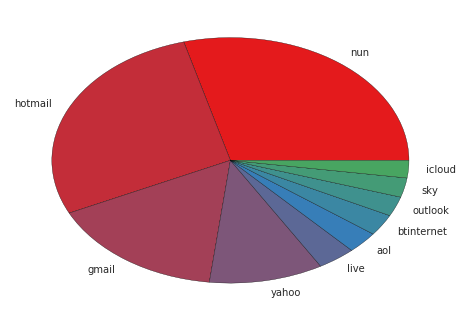

In [47]:
# labels = 'Frogs', 'Hogs', 'Dogs', 'Logs'
# fracs = [1, 30, 23, 10]
from matplotlib import cm
fracs=df_EmailProv.value_counts()[:10].values
labels=df_EmailProv.value_counts()[:10].index.tolist()
cs=cm.Set1(np.arange(40)/40.)
# explode = (0, 0.05, 0, 0)
f=plt.figure()
plt.pie(fracs, labels=labels, colors=cs)


**Define a email dictionary:**

In [38]:
email=df_EmailProv.value_counts()[:30].index
email

Index(['nun', 'hotmail', 'gmail', 'yahoo', 'live', 'aol', 'btinternet',
       'outlook', 'sky', 'icloud', 'googlemail', 'msn', 'ntlworld', 'talktalk',
       'virginmedia', 'me', 'blueyonder', 'ymail', 'tiscali', 'mail',
       'rocketmail', 'wowcher', 'btopenworld', 'gmx', 'talk21', 'wp', 'virgin',
       'btconnect', 'nhs', 'tesco'],
      dtype='object')

In [40]:
def email_class(x):
  if x in email:
    return x
  else:
    return 'Others'

In [41]:
df_EmailProv=df_EmailProv.progress_apply(lambda x: email_class(x))

Progress Bar: 100%|██████████| 220047/220047 [00:00<00:00, 512525.15it/s]


In [45]:
print(df_EmailProv.shape)
df_EmailProv.loc[[52432,52433]]

(220047,)


id     num_sess
52432  1           Others
       2           Others
       3           Others
       4           Others
52433  1            yahoo
       2            yahoo
       3            yahoo
       4            yahoo
Name: email, dtype: object

**Save df_EmailProv:**

In [46]:
%%time
with open( "../Data/Feature_Engineering/df_EmailProv.p", "wb" ) as f:
    pickle.dump(df_EmailProv, f)

CPU times: user 31 ms, sys: 7 ms, total: 38 ms
Wall time: 36.9 ms


---
### 2.7 User_agent

**Load data_base:**

In [58]:
%%time
with open( "../Data/Feature_Engineering/data_base.p", "rb" )  as f:
    data_base=pickle.load(f)

CPU times: user 3.85 s, sys: 1.45 s, total: 5.3 s
Wall time: 5.39 s


**Sample experiment of parsing**

In [59]:
type(data_base['user_agent'])

pandas.core.series.Series

In [60]:
user_agent=data_base['user_agent'].copy()

In [61]:
print(parse(user_agent[0]))
print('\n')
print(parse(user_agent[0]).browser)
print(parse(user_agent[0]).os)
print(parse(user_agent[0]).device)

iPhone / iOS 10.3.1 / Mobile Safari 10.0


Browser(family='Mobile Safari', version=(10, 0), version_string='10.0')
OperatingSystem(family='iOS', version=(10, 3, 1), version_string='10.3.1')
Device(family='iPhone', brand='Apple', model='iPhone')


- ** Parse data:**

In [62]:
df_sess=data_base.groupby(['id','num_sess']).first()

In [90]:
#user_agent_parse=list(map(lambda x: parse(user_agent[x]), range(0,2344636)))
# tqdm.pandas(tqdm())
# tqdmuser_agent_parse = df_groupby2['user_agent'].progress_apply(lambda x: parse(x))

user_agent_parse = df_sess['user_agent'].progress_apply(lambda x: parse(x))
print('user_agent_parse finished')

# data_browser = user_agent_parse.apply(lambda x: x.browser)
data_browser_family = user_agent_parse.progress_apply(lambda x: x.browser.family)
data_browser_version_string = user_agent_parse.progress_apply(lambda x: x.browser.version_string)
print('data_browser finished')

# data_os = user_agent_parse.apply(lambda x: x.os)
data_os_family = user_agent_parse.progress_apply(lambda x: x.os.family)
data_os_version_string = user_agent_parse.progress_apply(lambda x: x.os.version_string)
print('data_os finished')

# data_device = user_agent_parse.apply(lambda x: x.device)
data_device_family = user_agent_parse.progress_apply(lambda x: x.device.family)
data_device_brand = user_agent_parse.progress_apply(lambda x: x.device.brand)
data_device_model = user_agent_parse.progress_apply(lambda x: x.device.model)
print('data_device finished')

Progress Bar:  21%|██        | 46337/220047 [00:00<00:00, 463363.81it/s]

user_agent_parse finished


Progress Bar:  15%|█▍        | 32647/220047 [00:00<00:00, 326467.20it/s]

data_browser finished


Progress Bar:  19%|█▉        | 42080/220047 [00:00<00:00, 420788.36it/s]

data_os finished


Progress Bar: 100%|██████████| 220047/220047 [00:00<00:00, 506504.01it/s]

data_device finished


- **Save Parsed data to csv:**

In [91]:
%%time
user_agent_parse.to_csv('../Data/Feature_Engineering/user_agent_parse.csv')

# data_browser.to_csv('../Data/data_browser.csv')
data_browser_family.to_csv('../Data/Feature_Engineering/data_browser_family.csv')
data_browser_version_string.to_csv('../Data/Feature_Engineering/data_browser_version_string.csv')

# data_os.to_csv('../Data/data_os.csv')
data_os_family.to_csv('../Data/Feature_Engineering/data_os_family.csv')
data_os_version_string.to_csv('../Data/Feature_Engineering/data_os_version_string.csv')

# data_device.to_csv('../Data/data_device.csv')
data_device_family.to_csv('../Data/Feature_Engineering/data_device_family.csv')
data_device_model.to_csv('../Data/Feature_Engineering/data_device_model.csv')
data_device_brand.to_csv('../Data/Feature_Engineering/data_device_brand.csv')
# Read saved csv:
# pd.read_csv('../Data/user_agent_parse.csv')

CPU times: user 6.15 s, sys: 119 ms, total: 6.26 s
Wall time: 6.27 s


- **Read user_agent data:**

In [63]:
%%time
# must add:
# ,header=None
# after the path to avoid making the first line become column names
user_agent=pd.read_csv('../Data/Feature_Engineering/user_agent_parse.csv',header=None)

data_browser_family=pd.read_csv('../Data/Feature_Engineering/data_browser_family.csv',header=None)
data_browser_version_string=pd.read_csv('../Data/Feature_Engineering/data_browser_version_string.csv',header=None)

data_os_family=pd.read_csv('../Data/Feature_Engineering/data_os_family.csv',header=None)
data_os_version_string=pd.read_csv('../Data/Feature_Engineering/data_os_version_string.csv',header=None)

data_device_family=pd.read_csv('../Data/Feature_Engineering/data_device_family.csv',header=None)
data_device_model=pd.read_csv('../Data/Feature_Engineering/data_device_model.csv',header=None)
data_device_brand=pd.read_csv('../Data/Feature_Engineering/data_device_brand.csv',header=None)

CPU times: user 498 ms, sys: 6 ms, total: 504 ms
Wall time: 503 ms


In [64]:
print(df_sess.shape)
print(type(df_sess))
print(data_browser_family.shape)
print(type(data_browser_family))

(220047, 28)
<class 'pandas.core.frame.DataFrame'>
(220047, 3)
<class 'pandas.core.frame.DataFrame'>


In [65]:
data_browser_family.loc[:4,2]

0    Mobile Safari
1    Mobile Safari
2    Mobile Safari
3    Mobile Safari
4           Chrome
Name: 2, dtype: object

---
- **df_BrowserFamily**

In [66]:
print(data_browser_family.shape)
data_browser_family[:3]

(220047, 3)


,0,1,2
0,1,1,Mobile Safari
1,1,2,Mobile Safari
2,1,3,Mobile Safari


In [67]:
data_browser_family.loc[:,2].value_counts()

Mobile Safari                 88059
Chrome                        72821
Samsung Internet              17578
IE                            12029
Edge                           8718
Safari                         5652
Firefox                        5146
Amazon Silk                    3198
IE Mobile                      2206
Chrome Mobile iOS              1634
Facebook                       1516
Mobile Safari UI/WKWebView      296
Firefox Mobile                  289
PhantomJS                       263
Other                           178
Opera                           174
moatbot                          74
BlackBerry WebKit                51
Maxthon                          50
Crosswalk                        25
Firefox iOS                      18
UC Browser                       16
Yandex Browser                   12
Iceweasel                        10
SeaMonkey                         9
Dragon                            8
Vivaldi                           6
Chromium                    

**plot section**

In [73]:
tmp.tolist()

[88059,
 72821,
 17578,
 12029,
 8718,
 5652,
 5146,
 3198,
 2206,
 1634,
 1516,
 296,
 289,
 263,
 178,
 174,
 74,
 51,
 50,
 25,
 18,
 16,
 12,
 10,
 9,
 8,
 6,
 6,
 2,
 2,
 1]

In [92]:
x=data_browser_family.loc[:,2].value_counts().index.tolist()
x

['Mobile Safari',
 'Chrome',
 'Samsung Internet',
 'IE',
 'Edge',
 'Safari',
 'Firefox',
 'Amazon Silk',
 'IE Mobile',
 'Chrome Mobile iOS',
 'Facebook',
 'Mobile Safari UI/WKWebView',
 'Firefox Mobile',
 'PhantomJS',
 'Other',
 'Opera',
 'moatbot',
 'BlackBerry WebKit',
 'Maxthon',
 'Crosswalk',
 'Firefox iOS',
 'UC Browser',
 'Yandex Browser',
 'Iceweasel',
 'SeaMonkey',
 'Dragon',
 'Vivaldi',
 'Chromium',
 'Opera Coast',
 'QQ Browser',
 'Apple Mail']

([<matplotlib.axis.XTick at 0x7fa3a4b0c240>,
 <a list of 31 Text xticklabel objects>)

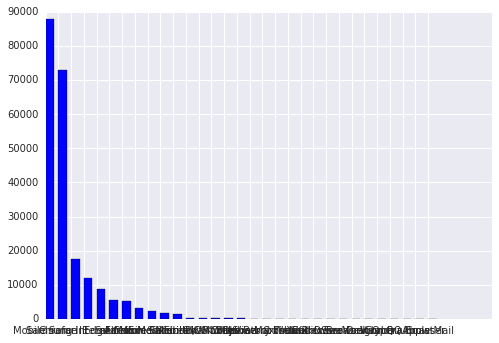

In [97]:
y=data_browser_family.loc[:,2].value_counts().tolist()
N = len(y)
bar_width = 0.35
label=data_browser_family.loc[:,2].value_counts().index.tolist()

x = range(N)
# x=data_browser_family.loc[:,2].index.tolist()
width =1/1.5
plt.bar(x, y, width, color="blue")
plt.xticks(x, label)

# plt.bar(tmp.tolist())
# plt.ylabel('Dwell time')
# plt.show()

# y = [3, 10, 7, 5, 3, 4.5, 6, 8.1]
# N = len(y)
# x = range(N)
# width = 1/1.5
# plt.bar(x, y, width, color="blue")

([<matplotlib.patches.Wedge at 0x7fa3a48f31d0>,
  <matplotlib.text.Text at 0x7fa3a494aa90>])

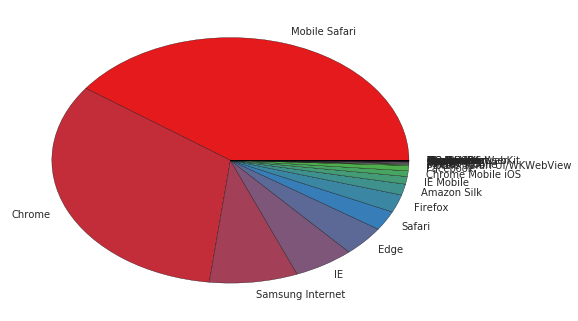

In [69]:
from matplotlib import cm
tmp=data_browser_family.loc[:,2].value_counts()
fracs=tmp.values
labels=tmp.index.tolist()
cs=cm.Set1(np.arange(40)/40.)
# explode = (0, 0.05, 0, 0)
f=plt.figure()
plt.pie(fracs, labels=labels, colors=cs)



In [137]:
df_BrowserFamily=data_browser_family.loc[:,2]

In [138]:
df_BrowserFamily[:3]

0    Mobile Safari
1    Mobile Safari
2    Mobile Safari
Name: 2, dtype: object

In [139]:
df_sess['Browser_Family']=df_BrowserFamily.values
df_BrowserFamily=df_sess['Browser_Family']

In [141]:
df_BrowserFamily[:5]

id  num_sess
1   1           Mobile Safari
    2           Mobile Safari
    3           Mobile Safari
    4           Mobile Safari
2   1                  Chrome
Name: Browser_Family, dtype: object

In [142]:
%%time
with open( "../Data/Feature_Engineering/df_BrowserFamily.p", "wb" ) as f:
    pickle.dump(df_BrowserFamily, f)

CPU times: user 8 ms, sys: 4 ms, total: 12 ms
Wall time: 12.6 ms


---
- **data_os_family**

In [143]:
data_os_family.loc[:,2].value_counts()

iOS                     93061
Windows                 59429
Android                 58267
Mac OS X                 7752
Other                    1050
Linux                     353
Ubuntu                     77
BlackBerry OS              51
BlackBerry Tablet OS        5
Fedora                      1
Firefox OS                  1
Name: 2, dtype: int64

In [145]:
df_OSfamily=data_os_family.loc[:,2]

In [146]:
df_sess['OS_family']=df_OSfamily.values
df_OSfamily=df_sess['OS_family']

In [147]:
df_OSfamily[:3]

id  num_sess
1   1           iOS
    2           iOS
    3           iOS
Name: OS_family, dtype: object

In [148]:
%%time
with open( "../Data/Feature_Engineering/df_OSfamily.p", "wb" ) as f:
    pickle.dump(df_OSfamily, f)

CPU times: user 11 ms, sys: 2 ms, total: 13 ms
Wall time: 12.9 ms


---
- **data_device_brand**

In [149]:
data_device_brand.loc[:,2].value_counts()

Apple      90865
Generic    39687
Samsung    18021
HTC         1044
LG          1027
Lenovo       769
Huawei       360
Spider        76
Archos        20
Sony          18
Name: 2, dtype: int64

In [150]:
df_deviceBrand=data_device_brand.loc[:,2]
print(df_deviceBrand.shape)

(220047,)


In [151]:
df_sess['Device_Brand']=df_deviceBrand.values
df_deviceBrand=df_sess['Device_Brand']

In [152]:
%%time
with open( "../Data/Feature_Engineering/df_deviceBrand.p", "wb" ) as f:
    pickle.dump(df_deviceBrand, f)

CPU times: user 11 ms, sys: 3 ms, total: 14 ms
Wall time: 14 ms


---
### 2.8 Referrer
Here, we only check if the first referrer is empty

**Load data_base:**

In [97]:
%%time
with open( "../Data/Feature_Engineering/data_base.p", "rb" )  as f:
    data_base=pickle.load(f)

CPU times: user 5.67 s, sys: 1.78 s, total: 7.45 s
Wall time: 7.64 s


In [98]:
df_sess=data_base.groupby(['id','num_sess']).nth(0)

In [99]:
df_sess.referrer.iloc[1]

''

In [100]:
def referrer_check(referrer):  
    if referrer == '':
        return 0
    else: 
        return 1

In [103]:
df_referrer=df_sess.referrer.progress_apply(lambda x: referrer_check(x))

Progress Bar: 100%|██████████| 220047/220047 [00:00<00:00, 530113.49it/s]


In [108]:
print(df_referrer.shape)
df_referrer[:20]

(220047,)


id  num_sess
1   1           0
    2           0
    3           0
    4           0
2   1           0
    2           0
    3           0
    4           0
3   1           0
    2           0
    3           0
4   1           0
    2           0
    3           0
5   1           0
    2           0
    3           0
6   1           1
    2           1
    3           1
Name: referrer, dtype: int64

**Save df_referrer**

In [109]:
%%time
with open( "../Data/Feature_Engineering/df_referrer.p", "wb" ) as f:
    pickle.dump(df_referrer, f)

CPU times: user 6 ms, sys: 4 ms, total: 10 ms
Wall time: 26.8 ms


### 2.9 Payment Type

In [47]:
%%time
with open( "../Data/Feature_Engineering/data_base.p", "rb" )  as f:
    data_base=pickle.load(f)
    
df_sess=data_base.groupby(['id','num_sess']).last()

CPU times: user 8.54 s, sys: 1.15 s, total: 9.69 s
Wall time: 9.68 s


In [55]:
df_paymentType=df_sess['payment_type'].copy()
print(df_paymentType.shape)
df_paymentType.loc[[52432,52433]]

(220047,)


id     num_sess
52432  1             credit_card
       2                    None
       3                    None
       4                    None
52433  1           paypalExpress
       2                    None
       3                    None
       4                    None
Name: payment_type, dtype: object

**Save df_paymentType**

In [56]:
%%time
with open( "../Data/Feature_Engineering/df_paymentType.p", "wb" ) as f:
    pickle.dump(df_paymentType, f)

CPU times: user 9 ms, sys: 4 ms, total: 13 ms
Wall time: 37.6 ms


### 2.10 Product_price

In [57]:
%%time
with open( "../Data/Feature_Engineering/data_base.p", "rb" )  as f:
    data_base=pickle.load(f)
    
df_sess=data_base.groupby(['id','num_sess']).last()

CPU times: user 8.8 s, sys: 2.15 s, total: 11 s
Wall time: 10.9 s


**Experiment**

In [79]:
print(df_sess['product_price'].count())
df_sess['product_price'].iloc[3]

186627


'9'

In [76]:
string='2,500.00'
string.replace(',','')

'2500.00'

**Find df_productPrice**

In [80]:
def product_price_replace(x):
  x=x.replace(',','')
  try:
    return(float(x))
  except ValueError:
    return 0

In [82]:
df_productPrice=df_sess['product_price'].apply(lambda x: product_price_replace(x) if not pd.isnull(x) else 0)

In [90]:
print('number of not well-defined data:',sum(df_productPrice!=0))
print('therefore info loss is very few')
print(df_productPrice.shape)

number of not well-defined data: 186606
therefore info loss is very few
(220047,)


**Save df_productPrice**

In [91]:
%%time
with open( "../Data/Feature_Engineering/df_productPrice.p", "wb" ) as f:
    pickle.dump(df_productPrice, f)

CPU times: user 5 ms, sys: 3 ms, total: 8 ms
Wall time: 7.17 ms


### 2.11 Product_save

In [92]:
%%time
with open( "../Data/Feature_Engineering/data_base.p", "rb" )  as f:
    data_base=pickle.load(f)
    
df_sess=data_base.groupby(['id','num_sess']).last()

CPU times: user 8.9 s, sys: 1.22 s, total: 10.1 s
Wall time: 10.1 s


In [103]:
print('number of nonNull product_save: ',df_sess.product_save.count())
print(df_sess.product_save[1][3])
print(type(df_sess.product_save[1][3]))

number of nonNull product_save:  174791
75%
<class 'str'>


In [100]:
def product_save_clean(x):
  x=x.replace('%','')
  try:
    return(float(x))
  except ValueError:
    return 0

In [105]:
product_save_clean('50% de')

0

In [106]:
df_productSave=df_sess['product_save'].apply(lambda x: product_save_clean(x) if not pd.isnull(x) else 0)

In [112]:
print('number of nonNull product_save: ',df_sess.product_save.count())
print('After the funciton, #nonNull : ',sum(df_productSave!=0))
df_productSave.shape

number of nonNull product_save:  174791
After the funciton, #nonNull :  174761


(220047,)

In [113]:
df_productSave[:3]

id  num_sess
1   1            0.0
    2            0.0
    3           75.0
Name: product_save, dtype: float64

**Save df_productSave**

In [114]:
%%time
with open( "../Data/Feature_Engineering/df_productSave.p", "wb" ) as f:
    pickle.dump(df_productSave, f)

CPU times: user 5 ms, sys: 3 ms, total: 8 ms
Wall time: 7.14 ms


---
### 2.12 Total Value

In [115]:
%%time
with open( "../Data/Feature_Engineering/data_base.p", "rb" )  as f:
    data_base=pickle.load(f)
    
df_sess=data_base.groupby(['id','num_sess']).last()

CPU times: user 11.2 s, sys: 1.3 s, total: 12.5 s
Wall time: 12.5 s


In [122]:
print('number of nonNull product_save: ',df_sess.total.count())
print(df_sess.total[1][3])
print(type(df_sess.total[1][3]))

number of nonNull product_save:  186559
9
<class 'str'>


In [121]:
def total(x):
  try:
    return(float(x))
  except ValueError:
    return 0

In [123]:
df_total=df_sess['total'].apply(lambda x: total(x) if not pd.isnull(x) else 0)

In [127]:
print('number of nonNull product_save: ',df_sess.total.count())
print('After the funciton, #nonNull : ',sum(df_total!=0))

number of nonNull product_save:  186559
After the funciton, #nonNull :  180539


In [130]:
print(df_total.shape)
df_total[:3]

(220047,)


id  num_sess
1   1           0.0
    2           0.0
    3           9.0
Name: total, dtype: float64

**Save df_total**

In [131]:
%%time
with open( "../Data/Feature_Engineering/df_total.p", "wb" ) as f:
    pickle.dump(df_total, f)

CPU times: user 5 ms, sys: 3 ms, total: 8 ms
Wall time: 7.21 ms


---
### 2.13 City

**Load data_base**

In [174]:
with open( "../Data/data_final.p", "rb" )  as f:
    data=pickle.load(f)

**Add city as a feature**

In [175]:
df_sess=data.groupby(['id','num_sess']).last()
print(df_sess.shape)

(220047, 31)


In [181]:
df_sess.city.value_counts()[:50]

London                 20255
Manchester              4353
Birmingham              2404
Derby                   2393
Liverpool               2033
Nottingham              2006
Glasgow                 1975
Leeds                   1737
Bristol                 1592
Edinburgh               1408
Sheffield               1296
El Segundo              1235
Leicester               1170
Coventry                 888
Cardiff                  805
Southampton              804
Northampton              734
Milton Keynes            721
Reading                  709
Newcastle Upon Tyne      697
Bolton                   664
Stoke-on-trent           654
Plymouth                 629
Oxford                   611
Stockport                574
Preston                  567
Brighton                 546
Belfast                  542
Wolverhampton            535
Croydon                  534
Hull                     522
Swindon                  511
Cambridge                505
Bradford                 492
Gloucester    

In [184]:
# create a dictionary
city=df_sess.city.value_counts().index

In [185]:
def city_class(x):
  if x in city:
    return x
  else:
    return 'Others'

In [186]:
df_city=df_sess['city'].apply(lambda x: city_class(x))

In [191]:
print(df_city.shape)
df_city[:10]

(220047,)


id  num_sess
1   1            Others
    2            Others
    3            Others
    4            Others
2   1            Others
    2            Others
    3            Others
    4            Others
3   1           Ashford
    2           Ashford
Name: city, dtype: object

**Save df_city**

In [192]:
%%time
with open( "../Data/Feature_Engineering/df_city.p", "wb" ) as f:
    pickle.dump(df_city, f)

CPU times: user 38 ms, sys: 5 ms, total: 43 ms
Wall time: 42.6 ms


---
### 2.14 Country

In [194]:
%%time
with open( "../Data/data_final.p", "rb" )  as f:
    data=pickle.load(f)

CPU times: user 5.66 s, sys: 893 ms, total: 6.55 s
Wall time: 6.56 s


In [195]:
df_sess=data.groupby(['id','num_sess']).last()
print(df_sess.shape)

(220047, 31)


In [197]:
df_sess.country.value_counts()[:15]

GB    212153
US      2842
IN      1106
DE       474
ES       378
CH       365
IE       332
LK       213
EU       187
FR       172
NL       151
IM       117
GR       100
RO        84
CY        82
Name: country, dtype: int64

In [200]:
#create dictonary
country=df_sess.country.value_counts()[:15].index
country

Index(['GB', 'US', 'IN', 'DE', 'ES', 'CH', 'IE', 'LK', 'EU', 'FR', 'NL', 'IM',
       'GR', 'RO', 'CY'],
      dtype='object')

In [201]:
def country_class(x):
    if x in country:
        return x
    else:
        return 'Others'

In [202]:
df_country=df_sess['country'].apply(lambda x: country_class(x))

In [205]:
sum(df_country=='US')

2842

**Save df_country**

In [206]:
%%time
with open( "../Data/Feature_Engineering/df_country.p", "wb" ) as f:
    pickle.dump(df_country, f)

CPU times: user 63 ms, sys: 5 ms, total: 68 ms
Wall time: 67.7 ms


---
# Features: All to One

In [4]:
%%time
with open( "../Data/Feature_Engineering/df_dateTime.p", "rb" ) as f:
    df_dateTime=pickle.load(f)
with open( "../Data/Feature_Engineering/df_DwellTime.p", "rb" ) as f:
    df_DwellTime=pickle.load(f)
with open( "../Data/Feature_Engineering/df_WeekDay.p", "rb" ) as f:
    df_WeekDay=pickle.load(f)
with open( "../Data/Feature_Engineering/df_month.p", "rb" ) as f:
    df_month=pickle.load(f)
with open( "../Data/Feature_Engineering/df_TimeOfDay.p", "rb" ) as f:
    df_TimeOfDay=pickle.load(f)
with open( "../Data/Feature_Engineering/df_last_CartStartedTime.p", "rb" ) as f:
    df_last_CartStartedTime=pickle.load(f)
with open( "../Data/Feature_Engineering/df_CartDwellTime.p", "rb" ) as f:
    df_CartDwellTime=pickle.load(f)
with open( "../Data/Feature_Engineering/df_ProductTimeLeft.p", "rb" ) as f:
    df_ProductTimeLeft=pickle.load(f)
with open( "../Data/Feature_Engineering/df_PageCount.p", "rb" ) as f:
    df_PageCount=pickle.load(f)
with open( "../Data/Feature_Engineering/df_ProductCount.p", "rb" ) as f:
    df_ProductCount=pickle.load(f)
with open( "../Data/Feature_Engineering/df_PopByViewed.p", "rb" ) as f:
    df_PopByViewed=pickle.load(f)
with open( "../Data/Feature_Engineering/df_PopByCart.p", "rb" ) as f:
    df_PopByCart=pickle.load(f)
with open( "../Data/Feature_Engineering/df_EmailProv.p", "rb" ) as f:
    df_EmailProv=pickle.load(f)
with open( "../Data/Feature_Engineering/df_BrowserFamily.p", "rb" ) as f:
    df_BrowserFamily=pickle.load(f)   
with open( "../Data/Feature_Engineering/df_OSfamily.p", "rb" ) as f:
    df_OSfamily=pickle.load(f)
with open( "../Data/Feature_Engineering/df_deviceBrand.p", "rb" ) as f:
    df_deviceBrand=pickle.load(f)
with open( "../Data/Feature_Engineering/df_referrer.p", "rb" ) as f:
    df_referrer=pickle.load(f)
with open( "../Data/Feature_Engineering/df_paymentType.p", "rb" ) as f:
    df_paymentType=pickle.load(f)
with open( "../Data/Feature_Engineering/df_productPrice.p", "rb" ) as f:
    df_productPrice=pickle.load(f)
with open( "../Data/Feature_Engineering/df_productSave.p", "rb" ) as f:
    df_productSave=pickle.load(f)
with open( "../Data/Feature_Engineering/df_total.p", "rb" ) as f:
    df_total=pickle.load(f)
with open( "../Data/Feature_Engineering/df_city.p", "rb" ) as f:
    df_city=pickle.load(f)
with open( "../Data/Feature_Engineering/df_country.p", "rb" ) as f:
    df_country=pickle.load(f)

CPU times: user 162 ms, sys: 123 ms, total: 285 ms
Wall time: 4.52 s


In [5]:
list_features=[df_dateTime,df_DwellTime, df_WeekDay,df_month,df_TimeOfDay,df_CartDwellTime,
              df_ProductTimeLeft,df_PageCount,df_ProductCount,df_PopByViewed,df_PopByCart,
              df_EmailProv,df_BrowserFamily,df_OSfamily,df_deviceBrand,df_referrer,df_paymentType,df_productPrice,
              df_productSave,df_total,df_city,df_country]

In [6]:
print(df_dateTime.shape)
print(df_DwellTime.shape)
print(df_WeekDay.shape)
print(df_month.shape)
print(df_TimeOfDay.shape)
print(df_CartDwellTime.shape)
print(df_ProductTimeLeft.shape)
print(df_PageCount.shape)
print(df_ProductCount.shape)
print(df_PopByViewed.shape)
print(df_PopByCart.shape)
print(df_EmailProv.shape)
print(df_BrowserFamily.shape)
print(df_OSfamily.shape)
print(df_deviceBrand.shape)
print(df_referrer.shape)
print(df_paymentType.shape)
print(df_productPrice.shape)
print(df_productSave.shape)
print(df_total.shape)
print(df_city.shape)
print(df_country.shape)

(220047,)
(220047,)
(220047,)
(220047,)
(220047,)
(220047,)
(220047,)
(220047,)
(220047,)
(220047,)
(220047,)
(220047,)
(220047,)
(220047,)
(220047,)
(220047,)
(220047,)
(220047,)
(220047,)
(220047,)
(220047,)
(220047,)


In [7]:
df_features=pd.concat(list_features, axis=1)

In [8]:
# Rename page_count_sess
df_features.rename(columns={0:'page_count_sess'},inplace=True)

In [9]:
df_features[:5]

datetime  dwell_time  weekday  month  time_of_day  \
id num_sess                                                          
1  1         1.495181e+09         0.0        4      5        28973   
   2         1.495202e+09         0.0        4      5        49919   
   3         1.496440e+09         0.0        4      6        78006   
   4         1.497018e+09         0.0        4      6        51790   
2  1         1.495805e+09         0.0        4      5        48327   

             cart_DwellTime  product_time_left  page_count_sess  \
id num_sess                                                       
1  1                    0.0                0.0                1   
   2                    0.0                0.0                1   
   3                    0.0           264004.0                1   
   4                    0.0            31014.0                1   
2  1                    0.0           552880.0                1   

             product_id_ProductViewed  PopByViewed  PopByCart email  \
id num_sess                                                           
1  1                                0          761       3465   nun   
   2                                0          761       3465   nun   
   3                                0          286        736   nun   
   4                                0          286        736   nun   
2  1                                1          710       1420   nun   

            Browser_Family OS_family Device_Brand  referrer payment_type  \
id num_sess                                                                
1  1         Mobile Safari       iOS        Apple         0         None   
   2         Mobile Safari       iOS        Apple         0         None   
   3         Mobile Safari       iOS        Apple         0         None   
   4         Mobile Safari       iOS        Apple         0         None   
2  1                Chrome   Windows          NaN         0         None   

             product_price  product_save  total    city country  
id num_sess                                                      
1  1                   0.0           0.0    0.0  Others      GB  
   2                   0.0           0.0    0.0  Others      GB  
   3                   9.0          75.0    9.0  Others      GB  
   4                   9.0          75.0    9.0  Others      GB  
2  1                  69.0          26.0   69.0  Others      GB

In [10]:
print(df_ProductCount.shape)
# print(df_lastProductInCart.shape)
# print(df_PopByViewed.shape)
# print(df_PopByCart.shape)
print(df_EmailProv.shape)
print(df_BrowserFamily.shape)
print(df_OSfamily.shape)
print(df_deviceBrand.shape)
print(df_referrer.shape)
print(df_paymentType.shape)
print(df_productPrice.shape)
print(df_productSave.shape)
print(df_total.shape)
print(df_city.shape)
print(df_country.shape)

(220047,)
(220047,)
(220047,)
(220047,)
(220047,)
(220047,)
(220047,)
(220047,)
(220047,)
(220047,)
(220047,)
(220047,)


In [60]:
# reset index and drop id column
df_features=df_features.reset_index().drop(['id'],axis=1)

In [61]:
print(df_features.shape)
df_features[:5]

(220047, 23)


,num_sess,datetime,dwell_time,weekday,month,time_of_day,cart_DwellTime,product_time_left,page_count_sess,product_id_ProductViewed,PopByViewed,PopByCart,email,Browser_Family,OS_family,Device_Brand,referrer,payment_type,product_price,product_save,total,city,country
0,1,1.495181e+09,0.0,4,5,28973,0.0,0.0,1,0,761,3465,nun,Mobile Safari,iOS,Apple,0,None,0.0,0.0,0.0,Others,GB
1,2,1.495202e+09,0.0,4,5,49919,0.0,0.0,1,0,761,3465,nun,Mobile Safari,iOS,Apple,0,None,0.0,0.0,0.0,Others,GB
2,3,1.496440e+09,0.0,4,6,78006,0.0,264004.0,1,0,286,736,nun,Mobile Safari,iOS,Apple,0,None,9.0,75.0,9.0,Others,GB
3,4,1.497018e+09,0.0,4,6,51790,0.0,31014.0,1,0,286,736,nun,Mobile Safari,iOS,Apple,0,None,9.0,75.0,9.0,Others,GB
4,1,1.495805e+09,0.0,4,5,48327,0.0,552880.0,1,1,710,1420,nun,Chrome,Windows,NaN,0,None,69.0,26.0,69.0,Others,GB


### - get df_features
**Save df_features**

In [62]:
%%time
with open( "../Data/Feature_Engineering/df_features.p", "wb" ) as f:
    pickle.dump(df_features, f)

CPU times: user 234 ms, sys: 76 ms, total: 310 ms
Wall time: 366 ms


In [5]:
%%time
with open( "../Data/Feature_Engineering/df_features.p", "rb" ) as f:
    df_features=pickle.load(f)

CPU times: user 106 ms, sys: 37 ms, total: 143 ms
Wall time: 175 ms


In [9]:
df_features.columns

Index(['num_sess', 'datetime', 'dwell_time', 'weekday', 'month', 'time_of_day',
       'cart_DwellTime', 'product_time_left', 'page_count_sess',
       'product_id_ProductViewed', 'PopByViewed', 'PopByCart', 'email',
       'Browser_Family', 'OS_family', 'Device_Brand', 'referrer',
       'payment_type', 'product_price', 'product_save', 'total', 'city',
       'country'],
      dtype='object')

In [10]:
df_features.shape

(220047, 23)

In [6]:
df_features[:20]

,num_sess,datetime,dwell_time,weekday,month,time_of_day,cart_DwellTime,product_time_left,page_count_sess,product_id_ProductViewed,PopByViewed,PopByCart,email,Browser_Family,OS_family,Device_Brand,referrer,payment_type,product_price,product_save,total,city,country
0,1,1.495181e+09,0.0,4,5,28973,0.0,0.0,1,0,761,3465,nun,Mobile Safari,iOS,Apple,0,None,0.00,0.0,0.00,Others,GB
1,2,1.495202e+09,0.0,4,5,49919,0.0,0.0,1,0,761,3465,nun,Mobile Safari,iOS,Apple,0,None,0.00,0.0,0.00,Others,GB
2,3,1.496440e+09,0.0,4,6,78006,0.0,264004.0,1,0,286,736,nun,Mobile Safari,iOS,Apple,0,None,9.00,75.0,9.00,Others,GB
3,4,1.497018e+09,0.0,4,6,51790,0.0,31014.0,1,0,286,736,nun,Mobile Safari,iOS,Apple,0,None,9.00,75.0,9.00,Others,GB
4,1,1.495805e+09,0.0,4,5,48327,0.0,552880.0,1,1,710,1420,nun,Chrome,Windows,NaN,0,None,69.00,26.0,69.00,Others,GB
5,2,1.497014e+09,1.0,4,6,48022,0.0,380369.0,1,1,1202,2738,nun,Chrome,Windows,NaN,0,None,229.00,27.0,229.00,Others,GB
6,3,1.497256e+09,0.0,0,6,30746,0.0,311235.0,1,1,19,43,nun,Chrome,Windows,NaN,0,None,9.00,64.0,9.00,Others,GB
7,4,1.497448e+09,68.0,2,6,49801,0.0,551353.0,2,2,829,1799,nun,Chrome,Windows,NaN,0,None,259.00,35.0,259.00,Others,GB
8,1,1.496513e+09,82.0,5,6,65057,0.0,194120.0,2,1,327,1230,nun,Chrome,Android,Generic,0,None,6.99,81.0,6.99,Ashford,GB
9,2,1.496704e+09,356.0,0,6,83069,118.0,348603.0,1,1,45,91,nun,Chrome,Android,Generic,0,None,12.00,87.0,12.00,Ashford,GB


### - Normalize data
**Split data into:**
- **float data**
- **category data**

In [ ]:
preprocessing.MinMaxScaler()

In [11]:
df_features.columns

Index(['num_sess', 'datetime', 'dwell_time', 'weekday', 'month', 'time_of_day',
       'cart_DwellTime', 'product_time_left', 'page_count_sess',
       'product_id_ProductViewed', 'PopByViewed', 'PopByCart', 'email',
       'Browser_Family', 'OS_family', 'Device_Brand', 'referrer',
       'payment_type', 'product_price', 'product_save', 'total', 'city',
       'country'],
      dtype='object')

In [12]:
list_float=['num_sess', 'datetime', 'dwell_time', 'weekday', 'month', 'time_of_day',
           'cart_DwellTime', 'product_time_left', 'page_count_sess',
           'product_id_ProductViewed', 'PopByViewed','PopByCart', 'referrer', 
           'product_price', 'product_save', 'total']

In [16]:
df_features_float=df_features[list_float].astype(np.float32)

In [17]:
list_norm=['datetime','time_of_day','product_time_left']

In [19]:

min_max_scaler=preprocessing.MinMaxScaler()

X_train_minmax = min_max_scaler.fit_transform(df_features_float)
X_train_minmax

array([[  0.00000000e+00,   1.39277293e-02,   1.44221532e-01, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  1.14942529e-02,   2.29204365e-02,   1.44221532e-01, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  2.29885057e-02,   5.53106322e-01,   1.44221532e-01, ...,
          1.79964007e-03,   7.50000000e-01,   9.00000000e-04],
       ..., 
       [  1.14942529e-02,   9.11553435e-01,   1.44221532e-01, ...,
          1.01779644e-01,   4.80000000e-01,   5.09000000e-02],
       [  2.29885057e-02,   9.11553435e-01,   1.44221532e-01, ...,
          1.01779644e-01,   4.80000000e-01,   5.09000000e-02],
       [  3.44827586e-02,   9.11827603e-01,   1.87454083e-01, ...,
          7.37852430e-02,   2.00000000e-01,   3.69000000e-02]])

In [20]:
X_train_minmax.shape

(220047, 16)

**category data:**

In [21]:
list_category=['email','Browser_Family', 'OS_family', 'Device_Brand','payment_type','city','country']

In [22]:
df_features_category=df_features[list_category]

In [ ]:
df_features=pd.concat([df_features_float,df_features_category],axis=1)

### - get_dummies

**Transfrom all integer and float64 to float32**

In [32]:
df_features.columns

Index(['num_sess', 'datetime', 'dwell_time', 'weekday', 'month', 'time_of_day',
       'cart_DwellTime', 'product_time_left', 'page_count_sess',
       'product_id_ProductViewed', 'PopByViewed', 'PopByCart', 'email',
       'Browser_Family', 'OS_family', 'Device_Brand', 'referrer',
       'payment_type', 'product_price', 'product_save', 'total', 'city',
       'country'],
      dtype='object')

In [33]:
list=['num_sess', 'datetime', 'dwell_time', 'weekday', 'month', 'time_of_day',
       'cart_DwellTime', 'product_time_left', 'page_count_sess',
       'product_id_ProductViewed', 'PopByViewed', 'PopByCart', 'email',
       'Browser_Family', 'OS_family', 'Device_Brand', 'referrer',
       'payment_type', 'product_price', 'product_save', 'total', 'city',
       'country']

In [34]:
df_features[list].shape

(220047, 23)

In [36]:
df_features[list][:5]

,num_sess,datetime,dwell_time,weekday,month,time_of_day,cart_DwellTime,product_time_left,page_count_sess,product_id_ProductViewed,PopByViewed,PopByCart,email,Browser_Family,OS_family,Device_Brand,referrer,payment_type,product_price,product_save,total,city,country
0,1,1.495181e+09,0.0,4,5,28973,0.0,0.0,1,0,761,3465,nun,Mobile Safari,iOS,Apple,0,None,0.0,0.0,0.0,Others,GB
1,2,1.495202e+09,0.0,4,5,49919,0.0,0.0,1,0,761,3465,nun,Mobile Safari,iOS,Apple,0,None,0.0,0.0,0.0,Others,GB
2,3,1.496440e+09,0.0,4,6,78006,0.0,264004.0,1,0,286,736,nun,Mobile Safari,iOS,Apple,0,None,9.0,75.0,9.0,Others,GB
3,4,1.497018e+09,0.0,4,6,51790,0.0,31014.0,1,0,286,736,nun,Mobile Safari,iOS,Apple,0,None,9.0,75.0,9.0,Others,GB
4,1,1.495805e+09,0.0,4,5,48327,0.0,552880.0,1,1,710,1420,nun,Chrome,Windows,NaN,0,None,69.0,26.0,69.0,Others,GB


In [38]:
df_features_float[:3].datetime

0    1.495181e+09
1    1.495202e+09
2    1.496440e+09
Name: datetime, dtype: float32

In [39]:
list_category=['email','Browser_Family', 'OS_family', 'Device_Brand','payment_type','city','country']

In [40]:
df_features_category=df_features[list_category]

In [108]:
df_features=pd.concat([df_features_float,df_features_category],axis=1)

In [110]:
df_features[:3]

,num_sess,datetime,dwell_time,weekday,month,time_of_day,cart_DwellTime,product_time_left,page_count_sess,product_id_ProductViewed,product_id_CartStarted,product_id_CartStarted,product_id_CartStarted,product_id_CartStarted,product_id_CartStarted,product_id_CartStarted,product_id_CartStarted,product_id_CartStarted,product_id_CartStarted,referrer,product_price,product_save,total,city,country,email,payment_type,Browser_Family,OS_family,Device_Brand
0,1.0,1.495181e+09,0.0,4.0,5.0,28973.0,0.0,0.0,1.0,0.0,3838997.0,761.0,3465.0,3838997.0,761.0,3465.0,3838997.0,761.0,3465.0,0.0,0.0,0.0,0.0,Others,GB,nun,None,Mobile Safari,iOS,Apple
1,2.0,1.495202e+09,0.0,4.0,5.0,49919.0,0.0,0.0,1.0,0.0,3838997.0,761.0,3465.0,3838997.0,761.0,3465.0,3838997.0,761.0,3465.0,0.0,0.0,0.0,0.0,Others,GB,nun,None,Mobile Safari,iOS,Apple
2,3.0,1.496440e+09,0.0,4.0,6.0,78006.0,0.0,264004.0,1.0,0.0,4096138.0,286.0,736.0,4096138.0,286.0,736.0,4096138.0,286.0,736.0,0.0,9.0,75.0,9.0,Others,GB,nun,None,Mobile Safari,iOS,Apple


**Get_dummies**

In [41]:
df_with_dummies = pd.get_dummies(df_features_category)

In [46]:
np.asarray(df_with_dummies[:5]).shape

(5, 2339)

In [111]:
# cols_to_transform = [ 'city','country','email','payment_type',
#                      'Browser_Family','OS_family','Device_Brand']
# df_with_dummies = pd.get_dummies(df_features, columns = cols_to_transform)

In [112]:
df_with_dummies.shape

(220047, 2362)

In [ ]:
# substitute all nan term to 0:
df_with_dummies=df_with_dummies.fillna(0)

**Save df_features**

In [ ]:
%%time
with open( "../Data/Feature_Engineering/df_features_dummies.p", "wb" ) as f:
    pickle.dump(df_with_dummies, f)

---
# Label: Basket Paid

**Load df_final:**

In [6]:
%%time
with open( "../Data/data_final.p", "rb" ) as f:
    data=pickle.load(f)

CPU times: user 5.61 s, sys: 2.35 s, total: 7.96 s
Wall time: 7.95 s


**show difference between basket_paid from browse and cart**

In [15]:
data[['id','num_sess','basket_paid_browsing','basket_paid_cart']].loc[range(3566,3575)]

,id,num_sess,basket_paid_browsing,basket_paid_cart
3566,182,3,None,False
3567,182,3,None,False
3568,183,1,None,True
3569,183,1,None,True
3570,183,1,None,True
3571,183,1,None,True
3572,183,1,True,True
3573,183,2,None,True
3574,183,2,None,True


## 0. Generate label

In [40]:
data0=data.sort_values(['id','num_sess','basket_paid_cart'])
df_label0=data0.groupby(['id','num_sess']).last()['basket_paid_cart']

In [41]:
print(df_label0.shape)
sum(df_label0.values=='True')

(220047,)


33677

In [42]:
def label_class(x):
  if x == 'True':
    return 1
  else:
    return 0

In [43]:
df_label=df_label0.apply(lambda x: label_class(x))

In [47]:
print(df_label.shape)
df_label.loc[[1,52432]]

(220047,)


id     num_sess
1      1           0
       2           0
       3           0
       4           0
52432  1           1
       2           1
       3           0
       4           0
Name: basket_paid_cart, dtype: int64

## 0.0 Save df_label

In [48]:
%%time
with open( "../Data/Feature_Engineering/df_label.p", "wb" ) as f:
    pickle.dump(df_label, f)

CPU times: user 5 ms, sys: 4 ms, total: 9 ms
Wall time: 44.8 ms


## 1. Investigate #True in Browse and Cart data

**Count #True from: **
<br>**1. basket_paid_browsing **
<br>**2. basket_paid_cart**

In [16]:
print('Following count is for df_data:')
print('count #True for basket_paid_browsing: ', sum(data['basket_paid_browsing']==True))
print('count #True for basket_paid_cart:     ', sum(data['basket_paid_cart']=='True'))

Following count is for df_data:
count #True for basket_paid_browsing:  20458
count #True for basket_paid_cart:      376486


**Get id_sess_true Table:**
<br>**This table would give you all (id, num_sess) with basket_paid_browsing = true.**

### For browse data:

In [17]:
# get 'id' and 'num_sess' column for basket_paid_browsing
id_sess_true = data[data['basket_paid_browsing']==True][['id','num_sess']]
print('#(id, num_sess) with label = True : ',len(id_sess_true))
print('\nid_sess table:')
id_sess_true[:2]

#(id, num_sess) with label = True :  20458

id_sess table:


,id,num_sess
2069,88,7
3572,183,1


In [18]:
print('drop duplicated term in id_sess_true and get shape: ', id_sess_true.drop_duplicates().shape)
print(len(id_sess_true),'!=',id_sess_true.drop_duplicates().shape[0])
print('Therefore, it is proved that there exists multi-buy within sessions')

drop duplicated term in id_sess_true and get shape:  (20037, 2)
20458 != 20037
Therefore, it is proved that there exists multi-buy within sessions


**True% analysis**

In [19]:
tmp=data.groupby(['id','num_sess'],sort=False).nth(0)
print('The shape of data_groupby with both T or F labels            :  ',tmp.shape)
print('Percentage of purchase by products (including multi-buy)) is :  ', 20458/tmp.shape[0]*100,'%')

The shape of data_groupby with both T or F labels            :   (220047, 31)
Percentage of purchase by products (including multi-buy)) is :   9.297104709448437 %


### For cart data:

In [22]:
# get 'id' and 'num_sess' column for basket_paid_browsing
id_sess_true = data[data['basket_paid_cart']=='True'][['id','num_sess']]
print('#(id, num_sess) with label = True (duplicated term dropped): ',len(id_sess_true.drop_duplicates()))
print('\nid_sess table:')
id_sess_true.drop_duplicates()[:2]

#(id, num_sess) with label = True (duplicated term dropped):  33677

id_sess table:


,id,num_sess
2063,88,7
3541,180,1


**True% analysis**

In [34]:
tmp=data.groupby(['id','num_sess'],sort=False).nth(0)
print('The shape of data_groupby with both T or F labels : ',tmp.shape)
print('Percentage of purchase by sessions is             : ', 33677/tmp.shape[0]*100,'%')

The shape of data_groupby with both T or F labels :  (220047, 28)
Percentage of purchase by sessions is             :  15.30445768404023 %


---
Use see if label is together with product id

In [15]:
pd.set_option('display.max_colwidth', -1)
data[(data['id']==183)&(data['num_sess']==2)][['id','num_sess','datetime','referrer','page_url',
                                              'product_viewed_browse','product_name','cart_startTime',
                                              'cart_started','basket_paid_browsing','product_id_ProductViewed'
                                              ,'product_id_CartStarted']]

,id,num_sess,datetime,referrer,page_url,product_viewed_browse,product_name,cart_startTime,cart_started,basket_paid_browsing,product_id_ProductViewed,product_id_CartStarted
3573,183,2,2017-05-20 18:53:29,https%3A%2F%2Fwww.wowcher.co.uk%2Fdeal%2Fshop%2F3611529%2F15-1-bluetooth-fitness-watch-12-99%3Fsearchresult%3Dtrue,https%3A%2F%2Fsecure.wowcher.co.uk%2Fcheckout%2F3611529%3Fproduct_id%3D337452%26quantity%3D1%26pay_deposit%3Dfalse,NaT,None,2017-05-20 18:54:00,NaT,None,NaN,3611529
3574,183,2,2017-05-20 18:53:30,https%3A%2F%2Fwww.wowcher.co.uk%2Fdeal%2Fshop%2F3611529%2F15-1-bluetooth-fitness-watch-12-99%3Fsearchresult%3Dtrue,https%3A%2F%2Fsecure.wowcher.co.uk%2Fcheckout%2F3611529%3Fproduct_id%3D337452%26quantity%3D1%26pay_deposit%3Dfalse,NaT,None,2017-05-20 18:54:00,NaT,None,NaN,3611529
3575,183,2,2017-05-20 18:53:30,https%3A%2F%2Fwww.wowcher.co.uk%2Fdeal%2Fshop%2F3611529%2F15-1-bluetooth-fitness-watch-12-99%3Fsearchresult%3Dtrue,https%3A%2F%2Fsecure.wowcher.co.uk%2Fcheckout%2F3611529%3Fproduct_id%3D337452%26quantity%3D1%26pay_deposit%3Dfalse,NaT,None,2017-05-20 18:54:00,NaT,None,NaN,3611529
3576,183,2,2017-05-20 18:53:30,https%3A%2F%2Fwww.wowcher.co.uk%2Fdeal%2Fshop%2F3611529%2F15-1-bluetooth-fitness-watch-12-99%3Fsearchresult%3Dtrue,https%3A%2F%2Fsecure.wowcher.co.uk%2Fcheckout%2F3611529%3Fproduct_id%3D337452%26quantity%3D1%26pay_deposit%3Dfalse,NaT,None,2017-05-20 18:54:00,NaT,None,NaN,3611529
3577,183,2,2017-05-20 18:53:30,https%3A%2F%2Fwww.wowcher.co.uk%2Fdeal%2Fshop%2F3611529%2F15-1-bluetooth-fitness-watch-12-99%3Fsearchresult%3Dtrue,https%3A%2F%2Fsecure.wowcher.co.uk%2Fcheckout%2F3611529%3Fproduct_id%3D337452%26quantity%3D1%26pay_deposit%3Dfalse,NaT,None,2017-05-20 18:54:00,NaT,None,NaN,3611529
3578,183,2,2017-05-20 18:53:36,https%3A%2F%2Fwww.wowcher.co.uk%2Fdeal%2Fshop%2F3611529%2F15-1-bluetooth-fitness-watch-12-99%3Fsearchresult%3Dtrue,https%3A%2F%2Fsecure.wowcher.co.uk%2Fcheckout%2F3611529%3Fproduct_id%3D337452%26quantity%3D1%26pay_deposit%3Dfalse,NaT,None,2017-05-20 18:54:00,NaT,None,NaN,3611529
3579,183,2,2017-05-20 18:53:36,https%3A%2F%2Fwww.wowcher.co.uk%2Fdeal%2Fshop%2F3611529%2F15-1-bluetooth-fitness-watch-12-99%3Fsearchresult%3Dtrue,https%3A%2F%2Fsecure.wowcher.co.uk%2Fcheckout%2F3611529%3Fproduct_id%3D337452%26quantity%3D1%26pay_deposit%3Dfalse,NaT,None,2017-05-20 18:54:00,NaT,None,NaN,3611529
3580,183,2,2017-05-20 18:53:36,https%3A%2F%2Fwww.wowcher.co.uk%2Fdeal%2Fshop%2F3611529%2F15-1-bluetooth-fitness-watch-12-99%3Fsearchresult%3Dtrue,https%3A%2F%2Fsecure.wowcher.co.uk%2Fcheckout%2F3611529%3Fproduct_id%3D337452%26quantity%3D1%26pay_deposit%3Dfalse,NaT,None,2017-05-20 18:54:00,NaT,None,NaN,3611529
3581,183,2,2017-05-20 18:53:39,https%3A%2F%2Fwww.wowcher.co.uk%2Fdeal%2Fshop%2F3611529%2F15-1-bluetooth-fitness-watch-12-99%3Fsearchresult%3Dtrue,https%3A%2F%2Fsecure.wowcher.co.uk%2Fcheckout%2F3611529%3Fproduct_id%3D337452%26quantity%3D1%26pay_deposit%3Dfalse,NaT,None,2017-05-20 18:54:00,NaT,None,NaN,3611529
3582,183,2,2017-05-20 18:53:39,https%3A%2F%2Fwww.wowcher.co.uk%2Fdeal%2Fshop%2F3611529%2F15-1-bluetooth-fitness-watch-12-99%3Fsearchresult%3Dtrue,https%3A%2F%2Fsecure.wowcher.co.uk%2Fcheckout%2F3611529%3Fproduct_id%3D337452%26quantity%3D1%26pay_deposit%3Dfalse,NaT,None,2017-05-20 18:54:00,NaT,None,NaN,3611529


In [6]:
data[data['basket_paid_browsing']==True][['id','num_sess','product_id_ProductViewed','product_id_CartStarted','basket_paid_browsing']]

,id,num_sess,product_id_ProductViewed,product_id_CartStarted,basket_paid_browsing
2069,88,7,NaN,0,True
3572,183,1,NaN,0,True
3585,183,2,NaN,0,True
3598,183,3,NaN,0,True
3610,183,4,NaN,0,True
7017,466,1,NaN,0,True
7026,466,3,NaN,0,True
7037,466,6,NaN,0,True
7045,466,7,NaN,0,True
7317,470,12,NaN,0,True


---

## 2. Check inner join of label=true from cart & browse

In [35]:
# browse data:
id_sess_true_browse = data[data['basket_paid_browsing']==True][['id','num_sess']]
id_sess_true_browse_drop=id_sess_true_browse.drop_duplicates()
print('browse: shape of id_sess for sessions : ', id_sess_true_browse_drop.shape)
# cart data:
id_sess_true_cart = data[data['basket_paid_cart']=='True'][['id','num_sess']]
id_sess_true_cart_drop=id_sess_true_cart.drop_duplicates()
print('cart:   shape of id_sess for sessions : ', id_sess_true_cart_drop.shape)

browse: shape of id_sess for sessions :  (20037, 2)
cart:   shape of id_sess for sessions :  (33677, 2)


In [36]:
joint_id_sess=pd.merge(id_sess_true_browse_drop, id_sess_true_cart_drop, how='inner', on=['id','num_sess'])

In [37]:
print(joint_id_sess.shape)
print('Conclusion:')
print('Cart data indeed contains more information of basket_paid.', 
      '\nOnly 20037-20034 = 3 "true" in browse data are not included in cart data.')

(20034, 2)
Conclusion:
Cart data indeed contains more information of basket_paid. 
Only 20037-20034 = 3 "true" in browse data are not included in cart data.


In [38]:
print('In order to use product name etc. features still decide to use browse data to get information')

In order to use product name etc. features still decide to use browse data to get information


---

## 3. Locate multi-buy
duplicated rows in id_sess_true for browse data indicating multi-buy

In [39]:
id_sess_true = data[data['basket_paid_browsing']==True][['id','num_sess']]

In [40]:
id_sess_multiBuy=id_sess_true[id_sess_true.duplicated(keep=False)] # keep=False would return all duplicated rows 
print(id_sess_multiBuy.shape)
id_sess_multiBuy[:10]

(707, 2)


,id,num_sess
17073,602,2
17074,602,2
17129,602,4
17130,602,4
19409,646,2
19410,646,2
22513,745,4
22514,745,4
22515,745,4
22516,745,4


In [41]:
# id_sess_multiBuy0
id_sess_multiBuy0=id_sess_multiBuy.drop_duplicates()
id_sess_multiBuy0.reset_index(inplace=True)


In [42]:
multiBuy_table=pd.merge(id_sess_multiBuy0,data_final,how='inner',on=['id','num_sess'])
print(multiBuy_table.shape)
multiBuy_table.drop_duplicates().shape

(19503, 31)


(19503, 31)

In [43]:
multiBuy_table.columns

Index(['index', 'id', 'num_sess', 'session_id', 'finger_print', 'datetime',
       'days', 'referrer', 'page_url', 'product_viewed_browse', 'cart_started',
       'basket_paid_browsing', 'product_name', 'product_save', 'product_price',
       'product_time_left', 'email', 'Post_Code', 'cart_startTime',
       'product_viewed_cart', 'total', 'basket_paid_cart', 'payment_type',
       'email_click_through', 'cart_firstTime', 'cart_lastTime',
       'basketInfoTime', 'ip_address', 'user_agent', 'city', 'country'],
      dtype='object')

In [57]:
tmp=multiBuy_table[['id','num_sess','datetime','session_id','product_viewed_browse','product_viewed_cart',
                    'product_name','basket_paid_browsing','product_save','product_price','product_time_left']]

In [58]:
print(multiBuy_table.loc[[12,13]].drop_duplicates().loc[12,'product_name'])
print(multiBuy_table.loc[[12,13]].drop_duplicates().loc[13,'product_name'])

Sooo Soft 54 Rolls Toilet Paper & 24 Roll Kitchen Towel Bundle
Sooo Soft 54 Rolls Toilet Paper & 24 Roll Kitchen Towel Bundle


In [59]:
tmp.loc[[12,13,14,15,16,17,18,19,20,21,22,23,24,25]].drop_duplicates()

,id,num_sess,datetime,session_id,product_viewed_browse,product_viewed_cart,product_name,basket_paid_browsing,product_save,product_price,product_time_left
12,602,4,2017-06-07 18:03:48,1ottm4i3gc5cd1auv2omnsq131,NaT,None,Sooo Soft 54 Rolls Toilet Paper & 24 Roll Kitc...,None,66%,14.99,25:4:39:20
14,602,4,2017-06-07 18:05:53,1ottm4i3gc5cd1auv2omnsq131,NaT,None,Sooo Soft 54 Rolls Toilet Paper & 24 Roll Kitc...,None,66%,14.99,25:4:39:20
16,602,4,2017-06-07 18:07:06,1ottm4i3gc5cd1auv2omnsq131,NaT,None,Sooo Soft 54 Rolls Toilet Paper & 24 Roll Kitc...,None,66%,14.99,25:4:39:20
18,602,4,2017-06-07 18:14:37,1ottm4i3gc5cd1auv2omnsq131,NaT,None,Sooo Soft 54 Rolls Toilet Paper & 24 Roll Kitc...,None,66%,14.99,25:4:39:20
20,602,4,2017-06-07 18:15:42,1ottm4i3gc5cd1auv2omnsq131,NaT,None,Sooo Soft 54 Rolls Toilet Paper & 24 Roll Kitc...,None,66%,14.99,25:4:39:20
22,602,4,2017-06-07 18:16:17,1ottm4i3gc5cd1auv2omnsq131,NaT,None,Sooo Soft 54 Rolls Toilet Paper & 24 Roll Kitc...,None,66%,14.99,25:4:39:20
24,602,4,2017-06-07 18:16:32,1ottm4i3gc5cd1auv2omnsq131,NaT,None,Sooo Soft 54 Rolls Toilet Paper & 24 Roll Kitc...,None,66%,14.99,25:4:39:20


In [ ]:
a=data[data['id']==117][data[data['id']==117]['num_sess']==4]
print(a.drop(['ip_address','city','country'],axis=1).shape)
a.drop(['ip_address','city','country'],axis=1).drop_duplicates()
# tmp[tmp['id']==745][tmp[tmp['id']==745]['num_sess']==4]

In [65]:
tmp[tmp['id']==602].shape

(62, 12)

In [94]:
tmp[tmp['id']==602]['num_sess']==2

# Appendix

**inner join id_sess_true and df_final**
<br>**to get df_browse_true from**

In [149]:
# inner join id_sess_true and df:
id_sess_true = data_final[data_final['basket_paid_browsing']==True][['id','num_sess']]
df_browse_true=pd.merge(id_sess_true,data_final,'inner', on=['id','num_sess'])

print('shape of df_browse_true original       :', df_browse_true.shape)
print('shape of df_browse_true drop duplicates:', df_browse_true.drop_duplicates().shape)

print('----------------------------------------------------------------------')

# original data:
print('#True for df_browse_true original       :', (df_browse_true[['basket_paid_browsing']]==True).sum()[0])

# drop duplicates and redo:
df_browse_true_drop=df_browse_true.drop_duplicates()[['basket_paid_browsing']]==True
print('#True for df_browse_true drop duplicates:', df_browse_true_drop.sum()[0])

shape of df_browse_true original       : (409098, 30)
shape of df_browse_true drop duplicates: (362369, 30)
----------------------------------------------------------------------
#True for df_browse_true original       : 21916
#True for df_browse_true drop duplicates: 20458


In [30]:
df_browse_true_drop=df_browse_true.drop_duplicates()
print('')
df_browse_true_drop[:3]

,id,num_sess,session_id,finger_print,datetime,days,referrer,page_url,product_viewed_browse,cart_started,basket_paid_browsing,product_name,product_save,product_price,product_time_left,email,Post_Code,cart_startTime,product_viewed_cart,total,basket_paid_cart,payment_type,email_click_through,cart_firstTime,cart_lastTime,basketInfoTime,ip_address,user_agent,city,country
0,88,7,18yrzevjvtdg12jfmdilomamv,27837983657a0de6b3a32ac9a95c22a3,2017-06-10 09:08:47,10,,https%3A%2F%2Fwww.wowcher.co.uk%2Fdeal%2Fshop%...,2017-06-10 09:08:47.019,NaT,None,Lace Up Invisible Push Up Bra - 4 Colours!,87%,7.99,01:13:51:12,None,joan1leech@yahoo.co.uk,1497085802688,None,7.99,True,None,False,2017-06-10 10:10:03,2017-06-10 10:12:54,1497086107,195.147.100.114,Mozilla/5.0+(Windows+NT+5.1;+rv:52.0)+Gecko/20...,None,GB
1,88,7,18yrzevjvtdg12jfmdilomamv,27837983657a0de6b3a32ac9a95c22a3,2017-06-10 09:10:03,10,,https%3A%2F%2Fwww.wowcher.co.uk%2Fdeal%2Fshop%...,NaT,2017-06-10 09:10:02.688,None,Lace Up Invisible Push Up Bra - 4 Colours!,87%,7.99,01:13:51:12,None,joan1leech@yahoo.co.uk,1497085802688,None,7.99,True,None,False,2017-06-10 10:10:03,2017-06-10 10:12:54,1497086107,195.147.100.114,Mozilla/5.0+(Windows+NT+5.1;+rv:52.0)+Gecko/20...,None,GB
2,88,7,18yrzevjvtdg12jfmdilomamv,27837983657a0de6b3a32ac9a95c22a3,2017-06-10 09:12:12,10,https%3A%2F%2Fwww.wowcher.co.uk%2Fdeal%2Fshop%...,https%3A%2F%2Fsecure.wowcher.co.uk%2Fcheckout%...,NaT,2017-06-10 09:12:11.368,None,Lace Up Invisible Push Up Bra - 4 Colours!,87%,7.99,01:13:51:12,None,joan1leech@yahoo.co.uk,1497085802688,None,7.99,True,None,False,2017-06-10 10:10:03,2017-06-10 10:12:54,1497086107,195.147.100.114,Mozilla/5.0+(Windows+NT+5.1;+rv:52.0)+Gecko/20...,None,GB


In [26]:
# task 1: is true only in final row of session?
# task 2: is it possible to have multiple true for same session?

task 1: is true only in final row of session?



For basket_paid_browsing:

In [38]:
df_browse_sort = df_browse_drop.sort_values(['id','num_sess','basket_paid_browsing']
                                        ,ascending=['True','True','False'])
df_browse_groupby=df_browse_sort.groupby(['id','num_sess'],sort=False).nth(0)

print(df_browse_groupby.shape)
count_true=sum(df_browse_groupby.basket_paid_browsing.apply(lambda x: x==True))
print('#True in df_browse_groupby (with ascending = [T,T,F]):')
print(count_true)



(20037, 28)
#True in df_browse_groupby (with ascending = [T,T,F]):
20037


In [39]:
sum(df_browse_groupby.basket_paid_browsing.apply(lambda x: x==True))

20037

In [29]:
Df_browse_sort=df_browse_drop.sort_values(['id','num_sess','basket_paid_browsing']
                                                      ,ascending=['True','True','True'])
Df_browse_groupby=Df_browse_sort.groupby(['id','num_sess'],sort=False).nth(0)


count_true = sum(Df_browse_groupby.basket_paid_browsing.apply(lambda x: x==True))
print('#True in df_browse_groupby (with ascending = [T,T,T]):')
print(count_true)


#True in df_browse_groupby (with ascending = [T,T,T]):
20037


---
**Test on id_sess_full, which has all columns of df_browse**

In [32]:
df_browse_sort=df_browse_drop.sort_values(['id','num_sess','basket_paid_browsing']
                                                      ,ascending=['True','True','False'])

# id_sess_full is all rows having true label (also having all columns)
id_sesee_full=df_browse_sort[df_browse_sort['basket_paid_browsing']==True]

print('shape of id_sess_full: ',id_sesee_full.shape)
print('shape of id_sess_full drop_duplicates： ',id_sesee_full.drop_duplicates().shape)

shape of id_sess_full:  (20458, 30)
shape of id_sess_full drop_duplicates：  (20458, 30)


In [41]:
df_browse_merge_full = pd.merge(id_sesee_full,data_sort_basket_paid_browsing
                                             ,how='inner', on=['id','num_sess'] ,suffixes=('','_y'))
print('df_browse_merge_full.shaped:\n',df_browse_merge_full.shape)
print('df_browse_merge_full.drop_duplicates().shape:\n',df_browse_merge_full.drop_duplicates().shape)
print('So there is no duplicated terms.')

df_browse_merge_full.shaped:
 (409098, 58)
df_browse_merge_full.drop_duplicates().shape:
 (409098, 58)
So there is no duplicated terms.


In [42]:
df_browse_groupby_full=df_browse_merge_full.groupby(['id','num_sess'],sort=False).nth(0)

print('#True of groupby:',sum(df_browse_groupby_full.basket_paid_browsing.apply(lambda x: x==True)))

#True of groupby: 20037


In [52]:
print('!=20458\nso it seems groupby would also decrease true label,implying there would be multi-purchase during session.')

!=20458
so it seems groupby would also decrease true label,implying there would be multi-purchase during session.


---

**Try to find multi-purchase**

In [69]:
df_browse_sort = df_browse_drop.sort_values(['id','num_sess','basket_paid_browsing']
                                        ,ascending=['True','True','False'])


In [117]:
tmp=df_browse_sort[['id','num_sess','basket_paid_browsing']].groupby(['id','num_sess'],sort=False).count()
print(tmp.sum())
tmp[:4]

basket_paid_browsing    20458
dtype: int64


basket_paid_browsing
id  num_sess                      
88  7                            1
183 1                            1
    2                            1
    3                            1

In [128]:
# tmp!=1
multi_buy=tmp[tmp['basket_paid_browsing']!=1]
multi_buy

basket_paid_browsing
id    num_sess                      
602   2                            2
      4                            2
646   2                            2
745   4                            4
923   1                            2
1027  2                            4
1055  2                            2
1182  4                            2
1440  1                            4
2155  5                            2
2164  3                            2
2271  5                            2
2871  1                            2
2875  1                            2
2963  1                            2
4145  2                            2
4248  2                            2
4409  1                            2
5066  7                            3
5493  4                            2
5529  1                            3
      2                            2
5581  1                            2
5677  2                            2
5867  3                            2
6032  4                            2
6542  2                            4
      4                            4
      9                            3
6573  1                            2
...                              ...
47120 2                            2
47194 1                            2
      3                            2
47221 2                            2
47330 4                            2
47368 4                            2
47410 2                            2
47420 3                            2
47577 1                            3
47675 2                            2
47732 1                            2
47734 1                            2
48198 3                            4
48514 1                            2
48800 2                            6
48981 1                            2
49319 1                            2
49856 11                           2
      12                           4
      23                           4
50113 3                            2
50159 2                            2
50777 1                            2
51396 4                            2
51474 5                            3
51568 3                            2
51606 1                            2
51824 3                            2
51902 1                            2
51979 1                            2

[286 rows x 1 columns]

In [ ]:
df_browse_sort = df_browse_drop.sort_values(['id','num_sess','basket_paid_browsing']
                                        ,ascending=['True','True','False'])
df_browse_groupby=df_browse_sort.groupby(['id','num_sess'],sort=False).count('basket_paid_browsing')

print('#True in df_browse_groupby (with ascending = [T,T,F]):')
print(sum(df_browse_groupby.basket_paid_browsing.apply(lambda x: x==True)))

In [ ]:
cols_to_transform = [ 'a', 'list', 'of', 'categorical', 'column', 'names' ]
df_with_dummies = pd.get_dummies( columns = cols_to_transform )
#http://fastml.com/converting-categorical-data-into-numbers-with-pandas-and-scikit-learn/

In [ ]:
#You can convert them into integer codes by using the categorical datatype.
column = column.astype('category')
column_encoded = column.cat.codes
# https://stackoverflow.com/questions/34915813/convert-text-columns-into-numbers-in-sklearn